### Cab-Driver Agent

In [72]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

#### Defining Time Matrix

In [73]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")
print("\nData shape:\n", np.shape(Time_matrix))
print("dimensions = ",len(Time_matrix.shape))


Data shape:
 (5, 5, 24, 7)
dimensions =  4


In [74]:
 # Call the environment
env = CabDriver()

#### Tracking the state-action pairs for checking convergence


In [75]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [76]:
class DQNAgent:
    def __init__(self, state_size, action_size,learning_rate):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        #self.discount_factor =0.9
        self.discount_factor =0.95

        #self.learning_rate =0.001
        #self.learning_rate = 0.01
        self.learning_rate = learning_rate

        self.epsilon = 1
        self.epsilon_max = 1
        #self.epsilon_decay =  .995
        #self.epsilon_decay = -0.0005
        #self.epsilon_decay =  .999
        self.epsilon_decay = 0.0005
        #self.epsilon_min = 0.001
        #self.epsilon_min = 0.00001
        self.epsilon_min = 0.01


        
        self.batch_size = 32        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)
        # Initialize the value of the states tracked
        self.states_tracked = []
        
        # We are going to track state [0,0,0] and action (0,2) at index 2 in the action space.
        self.track_state = np.array(env.state_encod_arch1([0,0,0])).reshape(1, 36)

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets       
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))

        # the output layer: output is of size num_actions
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model



    def get_action(self, state,env):
    # Write your code here:
    # get action from model using epsilon-greedy policy
    # Decay in ε after we generate each sample from the environment       
        possible_actions_index,actions = env.requests(state) # Find possible action indexes and append 0
        possible_actions_index.append(0)
        if np.random.rand() <= self.epsilon:
            return random.sample(possible_actions_index,1)[0]
        else:
            state = state.reshape(1, self.state_size)
            q_value = self.model.predict(state)
            # Give action with max q_value only amongst possible action
            return np.where(q_value[0] == np.max(np.array([q_value[0][i] for i in possible_actions_index])))[0][0]    
        
        
        
        


    def append_sample(self, state, action, reward, next_state,done):
    # Write your code here:
    # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action, reward, next_state,done))
    
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self,env):
        
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_output = np.zeros((self.batch_size, self.state_size)) # write here
            update_input = np.zeros((self.batch_size, self.state_size)) # write here
            
            actions, rewards, done = [], [], []
            
            for i in range(self.batch_size):
                state, action, reward, next_state, done_boolean = mini_batch[i]
                
                update_input[i] = state
                actions.append(action)
                rewards.append(reward)
                done.append(done_boolean)
                update_output[i] = next_state
                
                # Write your code from here
                
            # 1. Predict the target from earlier model           
            target = self.model.predict(update_input)
            
            # 2. Get the target for the Q-network
            target_qval = self.model.predict(update_output)
                
                #3. Update your 'update_output' and 'update_input' batch
            for i in range(self.batch_size):
                # Find possible actions from next state
                next_possible_actions_index,_ = env.requests(update_output[i])
                next_possible_actions_index.append(0)
                if not done[i]:
                    # Only take the max q_value from valid actions from next state
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(np.array([target_qval[i][j] for j in next_possible_actions_index]))
                else:
                    target[i][actions[i]] = rewards[i]
                
                
        # 4. Fit your model and track the loss values
            #print("Training Model")
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
            #print("Model Training Model")
    def save_tracking_states(self):
        # Use the model to predict the q_value of the state we are tacking.
        q_value = self.model.predict(self.track_state)
        
        # Grab the q_value of the action index that we are tracking.
        self.states_tracked.append(q_value[0][2])

    def save(self, name):
        self.model.save(name)

In [77]:
Episodes = 8000

### DQN block

In [78]:
#Testing with Episodes 8000
learning_rate = 0.01
agent = DQNAgent(36,21,learning_rate)
rewards_per_episode, episodes = [], []

for episode in range(Episodes):

    # Write code here
   
    # Call all the initialised variables of the environment
    state_space = env.state_space
    action_space = env.action_space
    state = env.state_init
    print("Initial State is ",state)
    time = 0
    #Call the DQN agent
    terminal_state = False
    score = 0
    action = agent.get_action(env.state_encod_arch1(state),env)
    score += env.reward_func(state,action_space[action],Time_matrix)
    next_state,ride_time = env.next_state_func(state,action_space[action],Time_matrix)
    time += ride_time
    if time >= 24*30:
        agent.append_sample(env.state_encod_arch1(state),action,score,env.state_encod_arch1(next_state),True)
    else:
        agent.append_sample(env.state_encod_arch1(state),action,score,env.state_encod_arch1(next_state),False)
    loop = 0
    while not terminal_state:
        
        # Write your code here
        
        if time >= 24*30:
            terminal_state = True
            pass
        state = next_state
        # 1. Pick epsilon-greedy action from possible actions for the current state
        action = agent.get_action(env.state_encod_arch1(state),env)
        # 2. Evaluate your reward and next state
        reward_curr_ride = env.reward_func(state,action_space[action],Time_matrix)
        score+= reward_curr_ride
        next_state,ride_time = env.next_state_func(next_state,action_space[action],Time_matrix)
        time += ride_time
        # 3. Append the experience to the memory
        if time >= 24*30:
            agent.append_sample(env.state_encod_arch1(state),action,reward_curr_ride,env.state_encod_arch1(next_state),True)
        else:
            agent.append_sample(env.state_encod_arch1(state),action,reward_curr_ride,env.state_encod_arch1(next_state),False)
        # 4. Train the model by calling function agent.train_model
        agent.train_model(env)
        #print('Time elapsed {} and current loop {}'.format(time,loop))
        loop+= 1
        # 5. Keep a track of rewards, Q-values, loss
    
    rewards_per_episode.append(score)   
    episodes.append(episode)
    
    if agent.epsilon > agent.epsilon_min:
        agent.epsilon *= agent.epsilon_decay
# every episode:
    print("episode {0}, reward {1}, memory_length {2}, epsilon {3}, time {4}, rides {5}".format(episode,
                                                                         score,
                                                                         len(agent.memory),
                                                                         agent.epsilon,time,loop))
    # every few episodes:
        # Save the Q_value of the state, action pair we are tracking
    if ((episode + 1) % 5 == 0):
        agent.save_tracking_states()
    if episode % 1000 == 0:
        # store q-values of some prespecified state-action pairs
        # q_dict = agent.store_q_values()

        # save model weights
        agent.save(name="model_weights.h5")

Initial State is  [1, 13, 1]
episode 0, reward -159.0, memory_length 126, epsilon 0.0005, time 728.0, rides 125
Initial State is  [1, 13, 1]
episode 1, reward -89.0, memory_length 255, epsilon 0.0005, time 732.0, rides 128
Initial State is  [1, 13, 1]
episode 2, reward 241.0, memory_length 373, epsilon 0.0005, time 722.0, rides 117
Initial State is  [1, 13, 1]
episode 3, reward 142.0, memory_length 476, epsilon 0.0005, time 734.0, rides 102
Initial State is  [1, 13, 1]
episode 4, reward 402.0, memory_length 610, epsilon 0.0005, time 730.0, rides 133
Initial State is  [1, 13, 1]
episode 5, reward 515.0, memory_length 732, epsilon 0.0005, time 735.0, rides 121
Initial State is  [1, 13, 1]
episode 6, reward 219.0, memory_length 851, epsilon 0.0005, time 736.0, rides 118
Initial State is  [1, 13, 1]
episode 7, reward 811.0, memory_length 984, epsilon 0.0005, time 729.0, rides 132
Initial State is  [1, 13, 1]
episode 8, reward 135.0, memory_length 1093, epsilon 0.0005, time 727.0, rides 108

episode 73, reward 687.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 125
Initial State is  [1, 13, 1]
episode 74, reward 492.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 121
Initial State is  [1, 13, 1]
episode 75, reward 474.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 136
Initial State is  [1, 13, 1]
episode 76, reward 623.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 140
Initial State is  [1, 13, 1]
episode 77, reward 863.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 121
Initial State is  [1, 13, 1]
episode 78, reward 893.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 125
Initial State is  [1, 13, 1]
episode 79, reward 641.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 122
Initial State is  [1, 13, 1]
episode 80, reward 407.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 117
Initial State is  [1, 13, 1]
episode 81, reward 623.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 133
Initial Stat

episode 146, reward 621.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 129
Initial State is  [1, 13, 1]
episode 147, reward 611.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 123
Initial State is  [1, 13, 1]
episode 148, reward 482.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 114
Initial State is  [1, 13, 1]
episode 149, reward 526.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 128
Initial State is  [1, 13, 1]
episode 150, reward 724.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 128
Initial State is  [1, 13, 1]
episode 151, reward 656.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 119
Initial State is  [1, 13, 1]
episode 152, reward 680.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 128
Initial State is  [1, 13, 1]
episode 153, reward 618.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 123
Initial State is  [1, 13, 1]
episode 154, reward 909.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 122
Ini

episode 218, reward 272.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 122
Initial State is  [1, 13, 1]
episode 219, reward 600.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 121
Initial State is  [1, 13, 1]
episode 220, reward 814.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 138
Initial State is  [1, 13, 1]
episode 221, reward 876.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 133
Initial State is  [1, 13, 1]
episode 222, reward 547.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 123
Initial State is  [1, 13, 1]
episode 223, reward 784.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 130
Initial State is  [1, 13, 1]
episode 224, reward 1052.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 122
Initial State is  [1, 13, 1]
episode 225, reward 619.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 138
Initial State is  [1, 13, 1]
episode 226, reward 823.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 124
In

episode 290, reward 453.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 131
Initial State is  [1, 13, 1]
episode 291, reward 626.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 133
Initial State is  [1, 13, 1]
episode 292, reward 572.0, memory_length 2000, epsilon 0.0005, time 739.0, rides 118
Initial State is  [1, 13, 1]
episode 293, reward 588.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 130
Initial State is  [1, 13, 1]
episode 294, reward 653.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 115
Initial State is  [1, 13, 1]
episode 295, reward 529.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 119
Initial State is  [1, 13, 1]
episode 296, reward 669.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 130
Initial State is  [1, 13, 1]
episode 297, reward 725.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 128
Initial State is  [1, 13, 1]
episode 298, reward 990.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 128
Ini

episode 362, reward 811.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 126
Initial State is  [1, 13, 1]
episode 363, reward 448.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 122
Initial State is  [1, 13, 1]
episode 364, reward 718.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 124
Initial State is  [1, 13, 1]
episode 365, reward 639.0, memory_length 2000, epsilon 0.0005, time 737.0, rides 130
Initial State is  [1, 13, 1]
episode 366, reward 611.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 120
Initial State is  [1, 13, 1]
episode 367, reward 642.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 127
Initial State is  [1, 13, 1]
episode 368, reward 692.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 133
Initial State is  [1, 13, 1]
episode 369, reward 672.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 130
Initial State is  [1, 13, 1]
episode 370, reward 372.0, memory_length 2000, epsilon 0.0005, time 738.0, rides 110
Ini

episode 434, reward 524.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 122
Initial State is  [1, 13, 1]
episode 435, reward 548.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 131
Initial State is  [1, 13, 1]
episode 436, reward 687.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 129
Initial State is  [1, 13, 1]
episode 437, reward 415.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 128
Initial State is  [1, 13, 1]
episode 438, reward 1025.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 130
Initial State is  [1, 13, 1]
episode 439, reward 634.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 141
Initial State is  [1, 13, 1]
episode 440, reward 841.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 134
Initial State is  [1, 13, 1]
episode 441, reward 604.0, memory_length 2000, epsilon 0.0005, time 721.0, rides 135
Initial State is  [1, 13, 1]
episode 442, reward 755.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 134
In

episode 506, reward 710.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 121
Initial State is  [1, 13, 1]
episode 507, reward 897.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 114
Initial State is  [1, 13, 1]
episode 508, reward 461.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 121
Initial State is  [1, 13, 1]
episode 509, reward 972.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 116
Initial State is  [1, 13, 1]
episode 510, reward 961.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 122
Initial State is  [1, 13, 1]
episode 511, reward 682.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 119
Initial State is  [1, 13, 1]
episode 512, reward 859.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 123
Initial State is  [1, 13, 1]
episode 513, reward 778.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 123
Initial State is  [1, 13, 1]
episode 514, reward 718.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 120
Ini

episode 578, reward 680.0, memory_length 2000, epsilon 0.0005, time 720.0, rides 125
Initial State is  [1, 13, 1]
episode 579, reward 363.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 134
Initial State is  [1, 13, 1]
episode 580, reward 924.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 125
Initial State is  [1, 13, 1]
episode 581, reward 691.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 120
Initial State is  [1, 13, 1]
episode 582, reward 558.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 136
Initial State is  [1, 13, 1]
episode 583, reward 601.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 117
Initial State is  [1, 13, 1]
episode 584, reward 616.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 123
Initial State is  [1, 13, 1]
episode 585, reward 850.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 120
Initial State is  [1, 13, 1]
episode 586, reward 362.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 140
Ini

episode 650, reward 699.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 119
Initial State is  [1, 13, 1]
episode 651, reward 508.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 123
Initial State is  [1, 13, 1]
episode 652, reward 967.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 135
Initial State is  [1, 13, 1]
episode 653, reward 670.0, memory_length 2000, epsilon 0.0005, time 737.0, rides 123
Initial State is  [1, 13, 1]
episode 654, reward 848.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 117
Initial State is  [1, 13, 1]
episode 655, reward 827.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 122
Initial State is  [1, 13, 1]
episode 656, reward 812.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 132
Initial State is  [1, 13, 1]
episode 657, reward 614.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 120
Initial State is  [1, 13, 1]
episode 658, reward 197.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 111
Ini

episode 722, reward 824.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 139
Initial State is  [1, 13, 1]
episode 723, reward 471.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 119
Initial State is  [1, 13, 1]
episode 724, reward 905.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 127
Initial State is  [1, 13, 1]
episode 725, reward 678.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 122
Initial State is  [1, 13, 1]
episode 726, reward 747.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 126
Initial State is  [1, 13, 1]
episode 727, reward 722.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 123
Initial State is  [1, 13, 1]
episode 728, reward 689.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 126
Initial State is  [1, 13, 1]
episode 729, reward 530.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 120
Initial State is  [1, 13, 1]
episode 730, reward 922.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 122
Ini

episode 794, reward 871.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 125
Initial State is  [1, 13, 1]
episode 795, reward 813.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 115
Initial State is  [1, 13, 1]
episode 796, reward 743.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 121
Initial State is  [1, 13, 1]
episode 797, reward 562.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 136
Initial State is  [1, 13, 1]
episode 798, reward 935.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 124
Initial State is  [1, 13, 1]
episode 799, reward 743.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 130
Initial State is  [1, 13, 1]
episode 800, reward 734.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 120
Initial State is  [1, 13, 1]
episode 801, reward 490.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 120
Initial State is  [1, 13, 1]
episode 802, reward 675.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 120
Ini

episode 866, reward 870.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 125
Initial State is  [1, 13, 1]
episode 867, reward 471.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 134
Initial State is  [1, 13, 1]
episode 868, reward 683.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 135
Initial State is  [1, 13, 1]
episode 869, reward 685.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 119
Initial State is  [1, 13, 1]
episode 870, reward 837.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 132
Initial State is  [1, 13, 1]
episode 871, reward 887.0, memory_length 2000, epsilon 0.0005, time 742.0, rides 131
Initial State is  [1, 13, 1]
episode 872, reward 470.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 109
Initial State is  [1, 13, 1]
episode 873, reward 704.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 127
Initial State is  [1, 13, 1]
episode 874, reward 853.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 130
Ini

episode 938, reward 693.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 128
Initial State is  [1, 13, 1]
episode 939, reward 559.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 126
Initial State is  [1, 13, 1]
episode 940, reward 557.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 136
Initial State is  [1, 13, 1]
episode 941, reward 554.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 124
Initial State is  [1, 13, 1]
episode 942, reward 756.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 128
Initial State is  [1, 13, 1]
episode 943, reward 808.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 124
Initial State is  [1, 13, 1]
episode 944, reward 593.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 133
Initial State is  [1, 13, 1]
episode 945, reward 688.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 123
Initial State is  [1, 13, 1]
episode 946, reward 768.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 127
Ini

episode 1010, reward 854.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 127
Initial State is  [1, 13, 1]
episode 1011, reward 692.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 125
Initial State is  [1, 13, 1]
episode 1012, reward 724.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 127
Initial State is  [1, 13, 1]
episode 1013, reward 811.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 127
Initial State is  [1, 13, 1]
episode 1014, reward 739.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 136
Initial State is  [1, 13, 1]
episode 1015, reward 770.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 126
Initial State is  [1, 13, 1]
episode 1016, reward 540.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 123
Initial State is  [1, 13, 1]
episode 1017, reward 570.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 126
Initial State is  [1, 13, 1]
episode 1018, reward 594.0, memory_length 2000, epsilon 0.0005, time 725.0, ride

episode 1082, reward 273.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 109
Initial State is  [1, 13, 1]
episode 1083, reward 591.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 129
Initial State is  [1, 13, 1]
episode 1084, reward 649.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 124
Initial State is  [1, 13, 1]
episode 1085, reward 884.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 117
Initial State is  [1, 13, 1]
episode 1086, reward 826.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 119
Initial State is  [1, 13, 1]
episode 1087, reward 779.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 135
Initial State is  [1, 13, 1]
episode 1088, reward 905.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 124
Initial State is  [1, 13, 1]
episode 1089, reward 833.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 136
Initial State is  [1, 13, 1]
episode 1090, reward 816.0, memory_length 2000, epsilon 0.0005, time 730.0, ride

episode 1154, reward 740.0, memory_length 2000, epsilon 0.0005, time 740.0, rides 129
Initial State is  [1, 13, 1]
episode 1155, reward 749.0, memory_length 2000, epsilon 0.0005, time 720.0, rides 133
Initial State is  [1, 13, 1]
episode 1156, reward 872.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 129
Initial State is  [1, 13, 1]
episode 1157, reward 883.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 128
Initial State is  [1, 13, 1]
episode 1158, reward 818.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 139
Initial State is  [1, 13, 1]
episode 1159, reward 807.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 122
Initial State is  [1, 13, 1]
episode 1160, reward 927.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 127
Initial State is  [1, 13, 1]
episode 1161, reward 620.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 132
Initial State is  [1, 13, 1]
episode 1162, reward 844.0, memory_length 2000, epsilon 0.0005, time 733.0, ride

episode 1226, reward 828.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 129
Initial State is  [1, 13, 1]
episode 1227, reward 807.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 138
Initial State is  [1, 13, 1]
episode 1228, reward 710.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 130
Initial State is  [1, 13, 1]
episode 1229, reward 788.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 130
Initial State is  [1, 13, 1]
episode 1230, reward 841.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 130
Initial State is  [1, 13, 1]
episode 1231, reward 814.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 138
Initial State is  [1, 13, 1]
episode 1232, reward 754.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 143
Initial State is  [1, 13, 1]
episode 1233, reward 879.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 142
Initial State is  [1, 13, 1]
episode 1234, reward 1062.0, memory_length 2000, epsilon 0.0005, time 730.0, rid

episode 1298, reward 614.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 121
Initial State is  [1, 13, 1]
episode 1299, reward 886.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 127
Initial State is  [1, 13, 1]
episode 1300, reward 963.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 141
Initial State is  [1, 13, 1]
episode 1301, reward 527.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 123
Initial State is  [1, 13, 1]
episode 1302, reward 978.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 119
Initial State is  [1, 13, 1]
episode 1303, reward 762.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 122
Initial State is  [1, 13, 1]
episode 1304, reward 919.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 134
Initial State is  [1, 13, 1]
episode 1305, reward 623.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 126
Initial State is  [1, 13, 1]
episode 1306, reward 839.0, memory_length 2000, epsilon 0.0005, time 730.0, ride

episode 1370, reward 750.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 118
Initial State is  [1, 13, 1]
episode 1371, reward 574.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 123
Initial State is  [1, 13, 1]
episode 1372, reward 824.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 122
Initial State is  [1, 13, 1]
episode 1373, reward 742.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 121
Initial State is  [1, 13, 1]
episode 1374, reward 835.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 128
Initial State is  [1, 13, 1]
episode 1375, reward 641.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 119
Initial State is  [1, 13, 1]
episode 1376, reward 1009.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 121
Initial State is  [1, 13, 1]
episode 1377, reward 909.0, memory_length 2000, epsilon 0.0005, time 739.0, rides 124
Initial State is  [1, 13, 1]
episode 1378, reward 761.0, memory_length 2000, epsilon 0.0005, time 729.0, rid

episode 1442, reward 876.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 120
Initial State is  [1, 13, 1]
episode 1443, reward 619.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 130
Initial State is  [1, 13, 1]
episode 1444, reward 572.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 142
Initial State is  [1, 13, 1]
episode 1445, reward 814.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 125
Initial State is  [1, 13, 1]
episode 1446, reward 484.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 122
Initial State is  [1, 13, 1]
episode 1447, reward 564.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 129
Initial State is  [1, 13, 1]
episode 1448, reward 785.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 123
Initial State is  [1, 13, 1]
episode 1449, reward 566.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 126
Initial State is  [1, 13, 1]
episode 1450, reward 995.0, memory_length 2000, epsilon 0.0005, time 736.0, ride

episode 1514, reward 1000.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 134
Initial State is  [1, 13, 1]
episode 1515, reward 581.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 121
Initial State is  [1, 13, 1]
episode 1516, reward 731.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 124
Initial State is  [1, 13, 1]
episode 1517, reward 567.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 126
Initial State is  [1, 13, 1]
episode 1518, reward 619.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 107
Initial State is  [1, 13, 1]
episode 1519, reward 606.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 115
Initial State is  [1, 13, 1]
episode 1520, reward 525.0, memory_length 2000, epsilon 0.0005, time 737.0, rides 126
Initial State is  [1, 13, 1]
episode 1521, reward 757.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 130
Initial State is  [1, 13, 1]
episode 1522, reward 488.0, memory_length 2000, epsilon 0.0005, time 728.0, rid

episode 1586, reward 759.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 118
Initial State is  [1, 13, 1]
episode 1587, reward 561.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 122
Initial State is  [1, 13, 1]
episode 1588, reward 746.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 122
Initial State is  [1, 13, 1]
episode 1589, reward 642.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 132
Initial State is  [1, 13, 1]
episode 1590, reward 511.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 131
Initial State is  [1, 13, 1]
episode 1591, reward 605.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 140
Initial State is  [1, 13, 1]
episode 1592, reward 807.0, memory_length 2000, epsilon 0.0005, time 742.0, rides 135
Initial State is  [1, 13, 1]
episode 1593, reward 534.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 137
Initial State is  [1, 13, 1]
episode 1594, reward 457.0, memory_length 2000, epsilon 0.0005, time 727.0, ride

episode 1658, reward 641.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 132
Initial State is  [1, 13, 1]
episode 1659, reward 826.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 115
Initial State is  [1, 13, 1]
episode 1660, reward 638.0, memory_length 2000, epsilon 0.0005, time 737.0, rides 128
Initial State is  [1, 13, 1]
episode 1661, reward 531.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 127
Initial State is  [1, 13, 1]
episode 1662, reward 938.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 135
Initial State is  [1, 13, 1]
episode 1663, reward 738.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 128
Initial State is  [1, 13, 1]
episode 1664, reward 827.0, memory_length 2000, epsilon 0.0005, time 737.0, rides 122
Initial State is  [1, 13, 1]
episode 1665, reward 1020.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 138
Initial State is  [1, 13, 1]
episode 1666, reward 829.0, memory_length 2000, epsilon 0.0005, time 721.0, rid

episode 1730, reward 609.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 117
Initial State is  [1, 13, 1]
episode 1731, reward 996.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 132
Initial State is  [1, 13, 1]
episode 1732, reward 722.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 120
Initial State is  [1, 13, 1]
episode 1733, reward 629.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 125
Initial State is  [1, 13, 1]
episode 1734, reward 674.0, memory_length 2000, epsilon 0.0005, time 738.0, rides 142
Initial State is  [1, 13, 1]
episode 1735, reward 879.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 144
Initial State is  [1, 13, 1]
episode 1736, reward 846.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 112
Initial State is  [1, 13, 1]
episode 1737, reward 696.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 126
Initial State is  [1, 13, 1]
episode 1738, reward 983.0, memory_length 2000, epsilon 0.0005, time 729.0, ride

episode 1802, reward 699.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 130
Initial State is  [1, 13, 1]
episode 1803, reward 645.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 129
Initial State is  [1, 13, 1]
episode 1804, reward 903.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 129
Initial State is  [1, 13, 1]
episode 1805, reward 809.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 140
Initial State is  [1, 13, 1]
episode 1806, reward 913.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 125
Initial State is  [1, 13, 1]
episode 1807, reward 795.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 126
Initial State is  [1, 13, 1]
episode 1808, reward 944.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 136
Initial State is  [1, 13, 1]
episode 1809, reward 701.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 132
Initial State is  [1, 13, 1]
episode 1810, reward 713.0, memory_length 2000, epsilon 0.0005, time 733.0, ride

episode 1874, reward 793.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 135
Initial State is  [1, 13, 1]
episode 1875, reward 884.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 132
Initial State is  [1, 13, 1]
episode 1876, reward 628.0, memory_length 2000, epsilon 0.0005, time 737.0, rides 122
Initial State is  [1, 13, 1]
episode 1877, reward 662.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 116
Initial State is  [1, 13, 1]
episode 1878, reward 644.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 124
Initial State is  [1, 13, 1]
episode 1879, reward 841.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 138
Initial State is  [1, 13, 1]
episode 1880, reward 570.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 121
Initial State is  [1, 13, 1]
episode 1881, reward 436.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 119
Initial State is  [1, 13, 1]
episode 1882, reward 607.0, memory_length 2000, epsilon 0.0005, time 731.0, ride

episode 1946, reward 850.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 134
Initial State is  [1, 13, 1]
episode 1947, reward 908.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 133
Initial State is  [1, 13, 1]
episode 1948, reward 538.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 118
Initial State is  [1, 13, 1]
episode 1949, reward 450.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 126
Initial State is  [1, 13, 1]
episode 1950, reward 907.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 127
Initial State is  [1, 13, 1]
episode 1951, reward 968.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 130
Initial State is  [1, 13, 1]
episode 1952, reward 1148.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 117
Initial State is  [1, 13, 1]
episode 1953, reward 937.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 130
Initial State is  [1, 13, 1]
episode 1954, reward 498.0, memory_length 2000, epsilon 0.0005, time 731.0, rid

episode 2018, reward 656.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 133
Initial State is  [1, 13, 1]
episode 2019, reward 553.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 135
Initial State is  [1, 13, 1]
episode 2020, reward 931.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 117
Initial State is  [1, 13, 1]
episode 2021, reward 924.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 133
Initial State is  [1, 13, 1]
episode 2022, reward 743.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 141
Initial State is  [1, 13, 1]
episode 2023, reward 827.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 128
Initial State is  [1, 13, 1]
episode 2024, reward 808.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 121
Initial State is  [1, 13, 1]
episode 2025, reward 914.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 131
Initial State is  [1, 13, 1]
episode 2026, reward 1032.0, memory_length 2000, epsilon 0.0005, time 731.0, rid

episode 2090, reward 673.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 133
Initial State is  [1, 13, 1]
episode 2091, reward 921.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 130
Initial State is  [1, 13, 1]
episode 2092, reward 880.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 130
Initial State is  [1, 13, 1]
episode 2093, reward 755.0, memory_length 2000, epsilon 0.0005, time 742.0, rides 128
Initial State is  [1, 13, 1]
episode 2094, reward 514.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 122
Initial State is  [1, 13, 1]
episode 2095, reward 782.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 127
Initial State is  [1, 13, 1]
episode 2096, reward 860.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 125
Initial State is  [1, 13, 1]
episode 2097, reward 428.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 140
Initial State is  [1, 13, 1]
episode 2098, reward 1028.0, memory_length 2000, epsilon 0.0005, time 733.0, rid

episode 2162, reward 815.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 124
Initial State is  [1, 13, 1]
episode 2163, reward 999.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 144
Initial State is  [1, 13, 1]
episode 2164, reward 682.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 135
Initial State is  [1, 13, 1]
episode 2165, reward 855.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 144
Initial State is  [1, 13, 1]
episode 2166, reward 841.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 123
Initial State is  [1, 13, 1]
episode 2167, reward 937.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 132
Initial State is  [1, 13, 1]
episode 2168, reward 1054.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 124
Initial State is  [1, 13, 1]
episode 2169, reward 838.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 131
Initial State is  [1, 13, 1]
episode 2170, reward 795.0, memory_length 2000, epsilon 0.0005, time 723.0, rid

episode 2234, reward 800.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 130
Initial State is  [1, 13, 1]
episode 2235, reward 849.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 139
Initial State is  [1, 13, 1]
episode 2236, reward 1187.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 136
Initial State is  [1, 13, 1]
episode 2237, reward 535.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 123
Initial State is  [1, 13, 1]
episode 2238, reward 808.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 140
Initial State is  [1, 13, 1]
episode 2239, reward 693.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 135
Initial State is  [1, 13, 1]
episode 2240, reward 1050.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 135
Initial State is  [1, 13, 1]
episode 2241, reward 799.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 138
Initial State is  [1, 13, 1]
episode 2242, reward 642.0, memory_length 2000, epsilon 0.0005, time 728.0, ri

episode 2306, reward 618.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 127
Initial State is  [1, 13, 1]
episode 2307, reward 581.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 133
Initial State is  [1, 13, 1]
episode 2308, reward 662.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 130
Initial State is  [1, 13, 1]
episode 2309, reward 1006.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 145
Initial State is  [1, 13, 1]
episode 2310, reward 983.0, memory_length 2000, epsilon 0.0005, time 720.0, rides 124
Initial State is  [1, 13, 1]
episode 2311, reward 946.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 138
Initial State is  [1, 13, 1]
episode 2312, reward 559.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 133
Initial State is  [1, 13, 1]
episode 2313, reward 716.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 134
Initial State is  [1, 13, 1]
episode 2314, reward 1037.0, memory_length 2000, epsilon 0.0005, time 726.0, ri

episode 2378, reward 849.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 135
Initial State is  [1, 13, 1]
episode 2379, reward 761.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 141
Initial State is  [1, 13, 1]
episode 2380, reward 878.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 137
Initial State is  [1, 13, 1]
episode 2381, reward 715.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 134
Initial State is  [1, 13, 1]
episode 2382, reward 733.0, memory_length 2000, epsilon 0.0005, time 738.0, rides 124
Initial State is  [1, 13, 1]
episode 2383, reward 819.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 120
Initial State is  [1, 13, 1]
episode 2384, reward 945.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 139
Initial State is  [1, 13, 1]
episode 2385, reward 918.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 136
Initial State is  [1, 13, 1]
episode 2386, reward 961.0, memory_length 2000, epsilon 0.0005, time 727.0, ride

episode 2450, reward 367.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 132
Initial State is  [1, 13, 1]
episode 2451, reward 660.0, memory_length 2000, epsilon 0.0005, time 738.0, rides 125
Initial State is  [1, 13, 1]
episode 2452, reward 781.0, memory_length 2000, epsilon 0.0005, time 721.0, rides 132
Initial State is  [1, 13, 1]
episode 2453, reward 705.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 122
Initial State is  [1, 13, 1]
episode 2454, reward 727.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 136
Initial State is  [1, 13, 1]
episode 2455, reward 781.0, memory_length 2000, epsilon 0.0005, time 737.0, rides 122
Initial State is  [1, 13, 1]
episode 2456, reward 525.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 116
Initial State is  [1, 13, 1]
episode 2457, reward 673.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 126
Initial State is  [1, 13, 1]
episode 2458, reward 871.0, memory_length 2000, epsilon 0.0005, time 726.0, ride

episode 2522, reward 998.0, memory_length 2000, epsilon 0.0005, time 737.0, rides 119
Initial State is  [1, 13, 1]
episode 2523, reward 833.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 126
Initial State is  [1, 13, 1]
episode 2524, reward 926.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 128
Initial State is  [1, 13, 1]
episode 2525, reward 719.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 126
Initial State is  [1, 13, 1]
episode 2526, reward 626.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 122
Initial State is  [1, 13, 1]
episode 2527, reward 875.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 122
Initial State is  [1, 13, 1]
episode 2528, reward 757.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 128
Initial State is  [1, 13, 1]
episode 2529, reward 790.0, memory_length 2000, epsilon 0.0005, time 721.0, rides 127
Initial State is  [1, 13, 1]
episode 2530, reward 517.0, memory_length 2000, epsilon 0.0005, time 731.0, ride

episode 2594, reward 889.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 134
Initial State is  [1, 13, 1]
episode 2595, reward 854.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 127
Initial State is  [1, 13, 1]
episode 2596, reward 618.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 135
Initial State is  [1, 13, 1]
episode 2597, reward 545.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 130
Initial State is  [1, 13, 1]
episode 2598, reward 844.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 124
Initial State is  [1, 13, 1]
episode 2599, reward 861.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 114
Initial State is  [1, 13, 1]
episode 2600, reward 635.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 145
Initial State is  [1, 13, 1]
episode 2601, reward 847.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 122
Initial State is  [1, 13, 1]
episode 2602, reward 712.0, memory_length 2000, epsilon 0.0005, time 732.0, ride

episode 2666, reward 757.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 139
Initial State is  [1, 13, 1]
episode 2667, reward 972.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 129
Initial State is  [1, 13, 1]
episode 2668, reward 810.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 126
Initial State is  [1, 13, 1]
episode 2669, reward 778.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 128
Initial State is  [1, 13, 1]
episode 2670, reward 750.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 127
Initial State is  [1, 13, 1]
episode 2671, reward 998.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 131
Initial State is  [1, 13, 1]
episode 2672, reward 596.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 123
Initial State is  [1, 13, 1]
episode 2673, reward 558.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 117
Initial State is  [1, 13, 1]
episode 2674, reward 673.0, memory_length 2000, epsilon 0.0005, time 735.0, ride

episode 2738, reward 883.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 129
Initial State is  [1, 13, 1]
episode 2739, reward 520.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 117
Initial State is  [1, 13, 1]
episode 2740, reward 906.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 128
Initial State is  [1, 13, 1]
episode 2741, reward 570.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 122
Initial State is  [1, 13, 1]
episode 2742, reward 1157.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 136
Initial State is  [1, 13, 1]
episode 2743, reward 847.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 126
Initial State is  [1, 13, 1]
episode 2744, reward 755.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 134
Initial State is  [1, 13, 1]
episode 2745, reward 633.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 135
Initial State is  [1, 13, 1]
episode 2746, reward 732.0, memory_length 2000, epsilon 0.0005, time 722.0, rid

episode 2810, reward 755.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 133
Initial State is  [1, 13, 1]
episode 2811, reward 829.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 129
Initial State is  [1, 13, 1]
episode 2812, reward 629.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 141
Initial State is  [1, 13, 1]
episode 2813, reward 796.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 139
Initial State is  [1, 13, 1]
episode 2814, reward 734.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 125
Initial State is  [1, 13, 1]
episode 2815, reward 817.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 130
Initial State is  [1, 13, 1]
episode 2816, reward 932.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 128
Initial State is  [1, 13, 1]
episode 2817, reward 871.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 133
Initial State is  [1, 13, 1]
episode 2818, reward 1018.0, memory_length 2000, epsilon 0.0005, time 732.0, rid

episode 2882, reward 1012.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 120
Initial State is  [1, 13, 1]
episode 2883, reward 790.0, memory_length 2000, epsilon 0.0005, time 720.0, rides 133
Initial State is  [1, 13, 1]
episode 2884, reward 674.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 144
Initial State is  [1, 13, 1]
episode 2885, reward 972.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 126
Initial State is  [1, 13, 1]
episode 2886, reward 781.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 125
Initial State is  [1, 13, 1]
episode 2887, reward 722.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 129
Initial State is  [1, 13, 1]
episode 2888, reward 657.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 131
Initial State is  [1, 13, 1]
episode 2889, reward 697.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 132
Initial State is  [1, 13, 1]
episode 2890, reward 472.0, memory_length 2000, epsilon 0.0005, time 725.0, rid

episode 2954, reward 829.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 114
Initial State is  [1, 13, 1]
episode 2955, reward 942.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 140
Initial State is  [1, 13, 1]
episode 2956, reward 508.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 137
Initial State is  [1, 13, 1]
episode 2957, reward 998.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 126
Initial State is  [1, 13, 1]
episode 2958, reward 758.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 139
Initial State is  [1, 13, 1]
episode 2959, reward 759.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 120
Initial State is  [1, 13, 1]
episode 2960, reward 1007.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 138
Initial State is  [1, 13, 1]
episode 2961, reward 698.0, memory_length 2000, epsilon 0.0005, time 737.0, rides 130
Initial State is  [1, 13, 1]
episode 2962, reward 687.0, memory_length 2000, epsilon 0.0005, time 729.0, rid

episode 3026, reward 816.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 132
Initial State is  [1, 13, 1]
episode 3027, reward 946.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 129
Initial State is  [1, 13, 1]
episode 3028, reward 495.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 126
Initial State is  [1, 13, 1]
episode 3029, reward 778.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 122
Initial State is  [1, 13, 1]
episode 3030, reward 849.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 127
Initial State is  [1, 13, 1]
episode 3031, reward 715.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 142
Initial State is  [1, 13, 1]
episode 3032, reward 796.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 134
Initial State is  [1, 13, 1]
episode 3033, reward 678.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 135
Initial State is  [1, 13, 1]
episode 3034, reward 942.0, memory_length 2000, epsilon 0.0005, time 725.0, ride

episode 3098, reward 694.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 127
Initial State is  [1, 13, 1]
episode 3099, reward 754.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 122
Initial State is  [1, 13, 1]
episode 3100, reward 660.0, memory_length 2000, epsilon 0.0005, time 721.0, rides 135
Initial State is  [1, 13, 1]
episode 3101, reward 769.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 139
Initial State is  [1, 13, 1]
episode 3102, reward 896.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 125
Initial State is  [1, 13, 1]
episode 3103, reward 907.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 130
Initial State is  [1, 13, 1]
episode 3104, reward 705.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 129
Initial State is  [1, 13, 1]
episode 3105, reward 856.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 136
Initial State is  [1, 13, 1]
episode 3106, reward 1079.0, memory_length 2000, epsilon 0.0005, time 725.0, rid

episode 3170, reward 866.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 131
Initial State is  [1, 13, 1]
episode 3171, reward 685.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 133
Initial State is  [1, 13, 1]
episode 3172, reward 731.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 133
Initial State is  [1, 13, 1]
episode 3173, reward 854.0, memory_length 2000, epsilon 0.0005, time 739.0, rides 128
Initial State is  [1, 13, 1]
episode 3174, reward 980.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 124
Initial State is  [1, 13, 1]
episode 3175, reward 685.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 126
Initial State is  [1, 13, 1]
episode 3176, reward 992.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 128
Initial State is  [1, 13, 1]
episode 3177, reward 756.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 134
Initial State is  [1, 13, 1]
episode 3178, reward 1004.0, memory_length 2000, epsilon 0.0005, time 722.0, rid

episode 3242, reward 1119.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 136
Initial State is  [1, 13, 1]
episode 3243, reward 583.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 131
Initial State is  [1, 13, 1]
episode 3244, reward 635.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 146
Initial State is  [1, 13, 1]
episode 3245, reward 724.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 128
Initial State is  [1, 13, 1]
episode 3246, reward 740.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 136
Initial State is  [1, 13, 1]
episode 3247, reward 678.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 143
Initial State is  [1, 13, 1]
episode 3248, reward 603.0, memory_length 2000, epsilon 0.0005, time 739.0, rides 147
Initial State is  [1, 13, 1]
episode 3249, reward 605.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 126
Initial State is  [1, 13, 1]
episode 3250, reward 593.0, memory_length 2000, epsilon 0.0005, time 725.0, rid

episode 3314, reward 769.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 144
Initial State is  [1, 13, 1]
episode 3315, reward 847.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 130
Initial State is  [1, 13, 1]
episode 3316, reward 988.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 127
Initial State is  [1, 13, 1]
episode 3317, reward 599.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 138
Initial State is  [1, 13, 1]
episode 3318, reward 713.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 121
Initial State is  [1, 13, 1]
episode 3319, reward 840.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 134
Initial State is  [1, 13, 1]
episode 3320, reward 847.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 121
Initial State is  [1, 13, 1]
episode 3321, reward 967.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 127
Initial State is  [1, 13, 1]
episode 3322, reward 595.0, memory_length 2000, epsilon 0.0005, time 726.0, ride

episode 3386, reward 901.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 129
Initial State is  [1, 13, 1]
episode 3387, reward 822.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 137
Initial State is  [1, 13, 1]
episode 3388, reward 904.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 120
Initial State is  [1, 13, 1]
episode 3389, reward 782.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 124
Initial State is  [1, 13, 1]
episode 3390, reward 955.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 147
Initial State is  [1, 13, 1]
episode 3391, reward 579.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 140
Initial State is  [1, 13, 1]
episode 3392, reward 810.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 131
Initial State is  [1, 13, 1]
episode 3393, reward 833.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 130
Initial State is  [1, 13, 1]
episode 3394, reward 991.0, memory_length 2000, epsilon 0.0005, time 727.0, ride

episode 3458, reward 857.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 144
Initial State is  [1, 13, 1]
episode 3459, reward 688.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 128
Initial State is  [1, 13, 1]
episode 3460, reward 731.0, memory_length 2000, epsilon 0.0005, time 721.0, rides 126
Initial State is  [1, 13, 1]
episode 3461, reward 943.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 123
Initial State is  [1, 13, 1]
episode 3462, reward 603.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 128
Initial State is  [1, 13, 1]
episode 3463, reward 500.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 142
Initial State is  [1, 13, 1]
episode 3464, reward 877.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 128
Initial State is  [1, 13, 1]
episode 3465, reward 666.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 122
Initial State is  [1, 13, 1]
episode 3466, reward 1037.0, memory_length 2000, epsilon 0.0005, time 733.0, rid

episode 3530, reward 968.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 127
Initial State is  [1, 13, 1]
episode 3531, reward 771.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 133
Initial State is  [1, 13, 1]
episode 3532, reward 1101.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 126
Initial State is  [1, 13, 1]
episode 3533, reward 835.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 152
Initial State is  [1, 13, 1]
episode 3534, reward 1051.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 133
Initial State is  [1, 13, 1]
episode 3535, reward 1007.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 135
Initial State is  [1, 13, 1]
episode 3536, reward 607.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 126
Initial State is  [1, 13, 1]
episode 3537, reward 864.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 129
Initial State is  [1, 13, 1]
episode 3538, reward 887.0, memory_length 2000, epsilon 0.0005, time 724.0, r

episode 3602, reward 1034.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 144
Initial State is  [1, 13, 1]
episode 3603, reward 790.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 126
Initial State is  [1, 13, 1]
episode 3604, reward 1045.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 136
Initial State is  [1, 13, 1]
episode 3605, reward 969.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 132
Initial State is  [1, 13, 1]
episode 3606, reward 696.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 139
Initial State is  [1, 13, 1]
episode 3607, reward 958.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 142
Initial State is  [1, 13, 1]
episode 3608, reward 757.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 122
Initial State is  [1, 13, 1]
episode 3609, reward 985.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 132
Initial State is  [1, 13, 1]
episode 3610, reward 528.0, memory_length 2000, epsilon 0.0005, time 728.0, ri

episode 3674, reward 845.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 131
Initial State is  [1, 13, 1]
episode 3675, reward 605.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 129
Initial State is  [1, 13, 1]
episode 3676, reward 1001.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 125
Initial State is  [1, 13, 1]
episode 3677, reward 486.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 127
Initial State is  [1, 13, 1]
episode 3678, reward 800.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 131
Initial State is  [1, 13, 1]
episode 3679, reward 853.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 125
Initial State is  [1, 13, 1]
episode 3680, reward 898.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 132
Initial State is  [1, 13, 1]
episode 3681, reward 634.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 125
Initial State is  [1, 13, 1]
episode 3682, reward 758.0, memory_length 2000, epsilon 0.0005, time 730.0, rid

episode 3746, reward 804.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 126
Initial State is  [1, 13, 1]
episode 3747, reward 900.0, memory_length 2000, epsilon 0.0005, time 737.0, rides 125
Initial State is  [1, 13, 1]
episode 3748, reward 928.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 144
Initial State is  [1, 13, 1]
episode 3749, reward 620.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 132
Initial State is  [1, 13, 1]
episode 3750, reward 1009.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 126
Initial State is  [1, 13, 1]
episode 3751, reward 802.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 134
Initial State is  [1, 13, 1]
episode 3752, reward 844.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 128
Initial State is  [1, 13, 1]
episode 3753, reward 813.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 132
Initial State is  [1, 13, 1]
episode 3754, reward 877.0, memory_length 2000, epsilon 0.0005, time 734.0, rid

episode 3818, reward 955.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 129
Initial State is  [1, 13, 1]
episode 3819, reward 628.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 121
Initial State is  [1, 13, 1]
episode 3820, reward 799.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 134
Initial State is  [1, 13, 1]
episode 3821, reward 834.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 136
Initial State is  [1, 13, 1]
episode 3822, reward 467.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 127
Initial State is  [1, 13, 1]
episode 3823, reward 963.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 128
Initial State is  [1, 13, 1]
episode 3824, reward 658.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 126
Initial State is  [1, 13, 1]
episode 3825, reward 700.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 134
Initial State is  [1, 13, 1]
episode 3826, reward 826.0, memory_length 2000, epsilon 0.0005, time 723.0, ride

episode 3890, reward 814.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 126
Initial State is  [1, 13, 1]
episode 3891, reward 894.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 127
Initial State is  [1, 13, 1]
episode 3892, reward 546.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 144
Initial State is  [1, 13, 1]
episode 3893, reward 699.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 132
Initial State is  [1, 13, 1]
episode 3894, reward 961.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 121
Initial State is  [1, 13, 1]
episode 3895, reward 613.0, memory_length 2000, epsilon 0.0005, time 737.0, rides 135
Initial State is  [1, 13, 1]
episode 3896, reward 543.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 133
Initial State is  [1, 13, 1]
episode 3897, reward 705.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 136
Initial State is  [1, 13, 1]
episode 3898, reward 842.0, memory_length 2000, epsilon 0.0005, time 730.0, ride

episode 3962, reward 967.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 131
Initial State is  [1, 13, 1]
episode 3963, reward 675.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 130
Initial State is  [1, 13, 1]
episode 3964, reward 708.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 131
Initial State is  [1, 13, 1]
episode 3965, reward 471.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 126
Initial State is  [1, 13, 1]
episode 3966, reward 904.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 121
Initial State is  [1, 13, 1]
episode 3967, reward 1046.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 130
Initial State is  [1, 13, 1]
episode 3968, reward 821.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 139
Initial State is  [1, 13, 1]
episode 3969, reward 941.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 135
Initial State is  [1, 13, 1]
episode 3970, reward 668.0, memory_length 2000, epsilon 0.0005, time 722.0, rid

episode 4034, reward 771.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 152
Initial State is  [1, 13, 1]
episode 4035, reward 667.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 136
Initial State is  [1, 13, 1]
episode 4036, reward 821.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 125
Initial State is  [1, 13, 1]
episode 4037, reward 410.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 142
Initial State is  [1, 13, 1]
episode 4038, reward 507.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 122
Initial State is  [1, 13, 1]
episode 4039, reward 822.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 120
Initial State is  [1, 13, 1]
episode 4040, reward 849.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 136
Initial State is  [1, 13, 1]
episode 4041, reward 826.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 148
Initial State is  [1, 13, 1]
episode 4042, reward 1171.0, memory_length 2000, epsilon 0.0005, time 732.0, rid

episode 4106, reward 860.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 135
Initial State is  [1, 13, 1]
episode 4107, reward 1085.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 137
Initial State is  [1, 13, 1]
episode 4108, reward 1165.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 134
Initial State is  [1, 13, 1]
episode 4109, reward 807.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 137
Initial State is  [1, 13, 1]
episode 4110, reward 990.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 139
Initial State is  [1, 13, 1]
episode 4111, reward 921.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 139
Initial State is  [1, 13, 1]
episode 4112, reward 913.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 120
Initial State is  [1, 13, 1]
episode 4113, reward 974.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 149
Initial State is  [1, 13, 1]
episode 4114, reward 671.0, memory_length 2000, epsilon 0.0005, time 726.0, ri

episode 4178, reward 824.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 144
Initial State is  [1, 13, 1]
episode 4179, reward 574.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 133
Initial State is  [1, 13, 1]
episode 4180, reward 758.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 130
Initial State is  [1, 13, 1]
episode 4181, reward 1063.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 131
Initial State is  [1, 13, 1]
episode 4182, reward 682.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 128
Initial State is  [1, 13, 1]
episode 4183, reward 771.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 123
Initial State is  [1, 13, 1]
episode 4184, reward 680.0, memory_length 2000, epsilon 0.0005, time 737.0, rides 115
Initial State is  [1, 13, 1]
episode 4185, reward 820.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 130
Initial State is  [1, 13, 1]
episode 4186, reward 641.0, memory_length 2000, epsilon 0.0005, time 722.0, rid

episode 4250, reward 645.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 136
Initial State is  [1, 13, 1]
episode 4251, reward 521.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 134
Initial State is  [1, 13, 1]
episode 4252, reward 632.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 146
Initial State is  [1, 13, 1]
episode 4253, reward 796.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 142
Initial State is  [1, 13, 1]
episode 4254, reward 976.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 129
Initial State is  [1, 13, 1]
episode 4255, reward 694.0, memory_length 2000, epsilon 0.0005, time 740.0, rides 132
Initial State is  [1, 13, 1]
episode 4256, reward 851.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 132
Initial State is  [1, 13, 1]
episode 4257, reward 879.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 127
Initial State is  [1, 13, 1]
episode 4258, reward 627.0, memory_length 2000, epsilon 0.0005, time 726.0, ride

episode 4322, reward 558.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 128
Initial State is  [1, 13, 1]
episode 4323, reward 830.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 137
Initial State is  [1, 13, 1]
episode 4324, reward 701.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 128
Initial State is  [1, 13, 1]
episode 4325, reward 749.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 125
Initial State is  [1, 13, 1]
episode 4326, reward 727.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 125
Initial State is  [1, 13, 1]
episode 4327, reward 664.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 132
Initial State is  [1, 13, 1]
episode 4328, reward 898.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 125
Initial State is  [1, 13, 1]
episode 4329, reward 1010.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 133
Initial State is  [1, 13, 1]
episode 4330, reward 856.0, memory_length 2000, epsilon 0.0005, time 734.0, rid

episode 4394, reward 733.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 128
Initial State is  [1, 13, 1]
episode 4395, reward 745.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 120
Initial State is  [1, 13, 1]
episode 4396, reward 729.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 126
Initial State is  [1, 13, 1]
episode 4397, reward 840.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 131
Initial State is  [1, 13, 1]
episode 4398, reward 735.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 120
Initial State is  [1, 13, 1]
episode 4399, reward 731.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 127
Initial State is  [1, 13, 1]
episode 4400, reward 1037.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 127
Initial State is  [1, 13, 1]
episode 4401, reward 841.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 130
Initial State is  [1, 13, 1]
episode 4402, reward 760.0, memory_length 2000, epsilon 0.0005, time 731.0, rid

episode 4466, reward 690.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 135
Initial State is  [1, 13, 1]
episode 4467, reward 561.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 119
Initial State is  [1, 13, 1]
episode 4468, reward 747.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 137
Initial State is  [1, 13, 1]
episode 4469, reward 974.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 130
Initial State is  [1, 13, 1]
episode 4470, reward 781.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 137
Initial State is  [1, 13, 1]
episode 4471, reward 837.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 135
Initial State is  [1, 13, 1]
episode 4472, reward 917.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 133
Initial State is  [1, 13, 1]
episode 4473, reward 876.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 134
Initial State is  [1, 13, 1]
episode 4474, reward 952.0, memory_length 2000, epsilon 0.0005, time 729.0, ride

episode 4538, reward 954.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 128
Initial State is  [1, 13, 1]
episode 4539, reward 935.0, memory_length 2000, epsilon 0.0005, time 737.0, rides 136
Initial State is  [1, 13, 1]
episode 4540, reward 1092.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 141
Initial State is  [1, 13, 1]
episode 4541, reward 977.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 128
Initial State is  [1, 13, 1]
episode 4542, reward 594.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 142
Initial State is  [1, 13, 1]
episode 4543, reward 875.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 134
Initial State is  [1, 13, 1]
episode 4544, reward 788.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 122
Initial State is  [1, 13, 1]
episode 4545, reward 751.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 134
Initial State is  [1, 13, 1]
episode 4546, reward 541.0, memory_length 2000, epsilon 0.0005, time 731.0, rid

episode 4610, reward 767.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 146
Initial State is  [1, 13, 1]
episode 4611, reward 845.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 128
Initial State is  [1, 13, 1]
episode 4612, reward 896.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 129
Initial State is  [1, 13, 1]
episode 4613, reward 646.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 135
Initial State is  [1, 13, 1]
episode 4614, reward 765.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 143
Initial State is  [1, 13, 1]
episode 4615, reward 930.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 134
Initial State is  [1, 13, 1]
episode 4616, reward 702.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 119
Initial State is  [1, 13, 1]
episode 4617, reward 721.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 132
Initial State is  [1, 13, 1]
episode 4618, reward 1002.0, memory_length 2000, epsilon 0.0005, time 726.0, rid

episode 4682, reward 1011.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 130
Initial State is  [1, 13, 1]
episode 4683, reward 790.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 145
Initial State is  [1, 13, 1]
episode 4684, reward 639.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 123
Initial State is  [1, 13, 1]
episode 4685, reward 966.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 134
Initial State is  [1, 13, 1]
episode 4686, reward 749.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 135
Initial State is  [1, 13, 1]
episode 4687, reward 835.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 133
Initial State is  [1, 13, 1]
episode 4688, reward 941.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 133
Initial State is  [1, 13, 1]
episode 4689, reward 590.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 132
Initial State is  [1, 13, 1]
episode 4690, reward 709.0, memory_length 2000, epsilon 0.0005, time 729.0, rid

episode 4754, reward 879.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 134
Initial State is  [1, 13, 1]
episode 4755, reward 823.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 137
Initial State is  [1, 13, 1]
episode 4756, reward 712.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 137
Initial State is  [1, 13, 1]
episode 4757, reward 872.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 129
Initial State is  [1, 13, 1]
episode 4758, reward 817.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 123
Initial State is  [1, 13, 1]
episode 4759, reward 1046.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 135
Initial State is  [1, 13, 1]
episode 4760, reward 776.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 118
Initial State is  [1, 13, 1]
episode 4761, reward 965.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 140
Initial State is  [1, 13, 1]
episode 4762, reward 972.0, memory_length 2000, epsilon 0.0005, time 730.0, rid

episode 4826, reward 713.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 120
Initial State is  [1, 13, 1]
episode 4827, reward 657.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 132
Initial State is  [1, 13, 1]
episode 4828, reward 900.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 126
Initial State is  [1, 13, 1]
episode 4829, reward 694.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 126
Initial State is  [1, 13, 1]
episode 4830, reward 728.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 129
Initial State is  [1, 13, 1]
episode 4831, reward 1123.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 139
Initial State is  [1, 13, 1]
episode 4832, reward 849.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 135
Initial State is  [1, 13, 1]
episode 4833, reward 812.0, memory_length 2000, epsilon 0.0005, time 737.0, rides 131
Initial State is  [1, 13, 1]
episode 4834, reward 1058.0, memory_length 2000, epsilon 0.0005, time 728.0, ri

episode 4898, reward 1056.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 130
Initial State is  [1, 13, 1]
episode 4899, reward 830.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 134
Initial State is  [1, 13, 1]
episode 4900, reward 903.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 143
Initial State is  [1, 13, 1]
episode 4901, reward 836.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 125
Initial State is  [1, 13, 1]
episode 4902, reward 732.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 124
Initial State is  [1, 13, 1]
episode 4903, reward 814.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 136
Initial State is  [1, 13, 1]
episode 4904, reward 818.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 129
Initial State is  [1, 13, 1]
episode 4905, reward 923.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 136
Initial State is  [1, 13, 1]
episode 4906, reward 930.0, memory_length 2000, epsilon 0.0005, time 725.0, rid

episode 4970, reward 937.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 129
Initial State is  [1, 13, 1]
episode 4971, reward 1041.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 137
Initial State is  [1, 13, 1]
episode 4972, reward 868.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 144
Initial State is  [1, 13, 1]
episode 4973, reward 975.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 129
Initial State is  [1, 13, 1]
episode 4974, reward 606.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 130
Initial State is  [1, 13, 1]
episode 4975, reward 1099.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 150
Initial State is  [1, 13, 1]
episode 4976, reward 636.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 135
Initial State is  [1, 13, 1]
episode 4977, reward 721.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 122
Initial State is  [1, 13, 1]
episode 4978, reward 1040.0, memory_length 2000, epsilon 0.0005, time 725.0, r

episode 5042, reward 850.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 127
Initial State is  [1, 13, 1]
episode 5043, reward 801.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 129
Initial State is  [1, 13, 1]
episode 5044, reward 1016.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 130
Initial State is  [1, 13, 1]
episode 5045, reward 695.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 121
Initial State is  [1, 13, 1]
episode 5046, reward 874.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 133
Initial State is  [1, 13, 1]
episode 5047, reward 636.0, memory_length 2000, epsilon 0.0005, time 721.0, rides 132
Initial State is  [1, 13, 1]
episode 5048, reward 927.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 137
Initial State is  [1, 13, 1]
episode 5049, reward 947.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 134
Initial State is  [1, 13, 1]
episode 5050, reward 966.0, memory_length 2000, epsilon 0.0005, time 728.0, rid

episode 5114, reward 603.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 128
Initial State is  [1, 13, 1]
episode 5115, reward 876.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 137
Initial State is  [1, 13, 1]
episode 5116, reward 669.0, memory_length 2000, epsilon 0.0005, time 720.0, rides 122
Initial State is  [1, 13, 1]
episode 5117, reward 963.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 129
Initial State is  [1, 13, 1]
episode 5118, reward 819.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 130
Initial State is  [1, 13, 1]
episode 5119, reward 1043.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 119
Initial State is  [1, 13, 1]
episode 5120, reward 932.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 138
Initial State is  [1, 13, 1]
episode 5121, reward 911.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 124
Initial State is  [1, 13, 1]
episode 5122, reward 635.0, memory_length 2000, epsilon 0.0005, time 726.0, rid

episode 5186, reward 759.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 130
Initial State is  [1, 13, 1]
episode 5187, reward 782.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 127
Initial State is  [1, 13, 1]
episode 5188, reward 727.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 133
Initial State is  [1, 13, 1]
episode 5189, reward 884.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 132
Initial State is  [1, 13, 1]
episode 5190, reward 664.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 131
Initial State is  [1, 13, 1]
episode 5191, reward 798.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 140
Initial State is  [1, 13, 1]
episode 5192, reward 702.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 138
Initial State is  [1, 13, 1]
episode 5193, reward 905.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 131
Initial State is  [1, 13, 1]
episode 5194, reward 801.0, memory_length 2000, epsilon 0.0005, time 731.0, ride

episode 5258, reward 720.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 138
Initial State is  [1, 13, 1]
episode 5259, reward 716.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 128
Initial State is  [1, 13, 1]
episode 5260, reward 885.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 122
Initial State is  [1, 13, 1]
episode 5261, reward 523.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 126
Initial State is  [1, 13, 1]
episode 5262, reward 687.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 128
Initial State is  [1, 13, 1]
episode 5263, reward 737.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 128
Initial State is  [1, 13, 1]
episode 5264, reward 458.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 120
Initial State is  [1, 13, 1]
episode 5265, reward 437.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 122
Initial State is  [1, 13, 1]
episode 5266, reward 567.0, memory_length 2000, epsilon 0.0005, time 728.0, ride

episode 5330, reward 952.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 124
Initial State is  [1, 13, 1]
episode 5331, reward 874.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 139
Initial State is  [1, 13, 1]
episode 5332, reward 714.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 128
Initial State is  [1, 13, 1]
episode 5333, reward 965.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 127
Initial State is  [1, 13, 1]
episode 5334, reward 788.0, memory_length 2000, epsilon 0.0005, time 738.0, rides 137
Initial State is  [1, 13, 1]
episode 5335, reward 822.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 122
Initial State is  [1, 13, 1]
episode 5336, reward 879.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 139
Initial State is  [1, 13, 1]
episode 5337, reward 814.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 140
Initial State is  [1, 13, 1]
episode 5338, reward 876.0, memory_length 2000, epsilon 0.0005, time 729.0, ride

episode 5402, reward 651.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 120
Initial State is  [1, 13, 1]
episode 5403, reward 885.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 127
Initial State is  [1, 13, 1]
episode 5404, reward 909.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 126
Initial State is  [1, 13, 1]
episode 5405, reward 910.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 127
Initial State is  [1, 13, 1]
episode 5406, reward 728.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 134
Initial State is  [1, 13, 1]
episode 5407, reward 801.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 133
Initial State is  [1, 13, 1]
episode 5408, reward 985.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 133
Initial State is  [1, 13, 1]
episode 5409, reward 661.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 119
Initial State is  [1, 13, 1]
episode 5410, reward 872.0, memory_length 2000, epsilon 0.0005, time 725.0, ride

episode 5474, reward 1097.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 129
Initial State is  [1, 13, 1]
episode 5475, reward 882.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 131
Initial State is  [1, 13, 1]
episode 5476, reward 873.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 131
Initial State is  [1, 13, 1]
episode 5477, reward 1109.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 137
Initial State is  [1, 13, 1]
episode 5478, reward 661.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 142
Initial State is  [1, 13, 1]
episode 5479, reward 670.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 130
Initial State is  [1, 13, 1]
episode 5480, reward 815.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 129
Initial State is  [1, 13, 1]
episode 5481, reward 853.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 127
Initial State is  [1, 13, 1]
episode 5482, reward 705.0, memory_length 2000, epsilon 0.0005, time 723.0, ri

episode 5546, reward 895.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 129
Initial State is  [1, 13, 1]
episode 5547, reward 665.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 125
Initial State is  [1, 13, 1]
episode 5548, reward 815.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 135
Initial State is  [1, 13, 1]
episode 5549, reward 868.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 133
Initial State is  [1, 13, 1]
episode 5550, reward 885.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 126
Initial State is  [1, 13, 1]
episode 5551, reward 1011.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 142
Initial State is  [1, 13, 1]
episode 5552, reward 1049.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 135
Initial State is  [1, 13, 1]
episode 5553, reward 736.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 133
Initial State is  [1, 13, 1]
episode 5554, reward 872.0, memory_length 2000, epsilon 0.0005, time 726.0, ri

episode 5618, reward 824.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 142
Initial State is  [1, 13, 1]
episode 5619, reward 660.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 137
Initial State is  [1, 13, 1]
episode 5620, reward 900.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 138
Initial State is  [1, 13, 1]
episode 5621, reward 957.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 126
Initial State is  [1, 13, 1]
episode 5622, reward 940.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 135
Initial State is  [1, 13, 1]
episode 5623, reward 819.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 128
Initial State is  [1, 13, 1]
episode 5624, reward 824.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 123
Initial State is  [1, 13, 1]
episode 5625, reward 947.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 141
Initial State is  [1, 13, 1]
episode 5626, reward 729.0, memory_length 2000, epsilon 0.0005, time 734.0, ride

episode 5690, reward 799.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 140
Initial State is  [1, 13, 1]
episode 5691, reward 980.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 131
Initial State is  [1, 13, 1]
episode 5692, reward 769.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 125
Initial State is  [1, 13, 1]
episode 5693, reward 899.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 138
Initial State is  [1, 13, 1]
episode 5694, reward 692.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 142
Initial State is  [1, 13, 1]
episode 5695, reward 1103.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 127
Initial State is  [1, 13, 1]
episode 5696, reward 979.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 129
Initial State is  [1, 13, 1]
episode 5697, reward 708.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 133
Initial State is  [1, 13, 1]
episode 5698, reward 586.0, memory_length 2000, epsilon 0.0005, time 733.0, rid

episode 5762, reward 519.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 123
Initial State is  [1, 13, 1]
episode 5763, reward 927.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 132
Initial State is  [1, 13, 1]
episode 5764, reward 1011.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 115
Initial State is  [1, 13, 1]
episode 5765, reward 816.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 129
Initial State is  [1, 13, 1]
episode 5766, reward 664.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 135
Initial State is  [1, 13, 1]
episode 5767, reward 884.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 144
Initial State is  [1, 13, 1]
episode 5768, reward 829.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 130
Initial State is  [1, 13, 1]
episode 5769, reward 641.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 118
Initial State is  [1, 13, 1]
episode 5770, reward 468.0, memory_length 2000, epsilon 0.0005, time 723.0, rid

episode 5834, reward 918.0, memory_length 2000, epsilon 0.0005, time 721.0, rides 148
Initial State is  [1, 13, 1]
episode 5835, reward 917.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 129
Initial State is  [1, 13, 1]
episode 5836, reward 1022.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 131
Initial State is  [1, 13, 1]
episode 5837, reward 870.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 128
Initial State is  [1, 13, 1]
episode 5838, reward 641.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 145
Initial State is  [1, 13, 1]
episode 5839, reward 767.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 146
Initial State is  [1, 13, 1]
episode 5840, reward 837.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 142
Initial State is  [1, 13, 1]
episode 5841, reward 716.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 139
Initial State is  [1, 13, 1]
episode 5842, reward 1038.0, memory_length 2000, epsilon 0.0005, time 727.0, ri

episode 5906, reward 939.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 132
Initial State is  [1, 13, 1]
episode 5907, reward 1020.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 131
Initial State is  [1, 13, 1]
episode 5908, reward 776.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 137
Initial State is  [1, 13, 1]
episode 5909, reward 927.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 130
Initial State is  [1, 13, 1]
episode 5910, reward 810.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 151
Initial State is  [1, 13, 1]
episode 5911, reward 945.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 130
Initial State is  [1, 13, 1]
episode 5912, reward 954.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 145
Initial State is  [1, 13, 1]
episode 5913, reward 866.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 135
Initial State is  [1, 13, 1]
episode 5914, reward 934.0, memory_length 2000, epsilon 0.0005, time 728.0, rid

episode 5978, reward 820.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 132
Initial State is  [1, 13, 1]
episode 5979, reward 1144.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 133
Initial State is  [1, 13, 1]
episode 5980, reward 725.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 138
Initial State is  [1, 13, 1]
episode 5981, reward 756.0, memory_length 2000, epsilon 0.0005, time 721.0, rides 132
Initial State is  [1, 13, 1]
episode 5982, reward 977.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 130
Initial State is  [1, 13, 1]
episode 5983, reward 810.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 137
Initial State is  [1, 13, 1]
episode 5984, reward 864.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 131
Initial State is  [1, 13, 1]
episode 5985, reward 1016.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 125
Initial State is  [1, 13, 1]
episode 5986, reward 924.0, memory_length 2000, epsilon 0.0005, time 736.0, ri

episode 6050, reward 836.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 129
Initial State is  [1, 13, 1]
episode 6051, reward 876.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 139
Initial State is  [1, 13, 1]
episode 6052, reward 958.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 119
Initial State is  [1, 13, 1]
episode 6053, reward 698.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 131
Initial State is  [1, 13, 1]
episode 6054, reward 1059.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 129
Initial State is  [1, 13, 1]
episode 6055, reward 937.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 138
Initial State is  [1, 13, 1]
episode 6056, reward 892.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 125
Initial State is  [1, 13, 1]
episode 6057, reward 890.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 138
Initial State is  [1, 13, 1]
episode 6058, reward 1079.0, memory_length 2000, epsilon 0.0005, time 733.0, ri

episode 6122, reward 994.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 118
Initial State is  [1, 13, 1]
episode 6123, reward 999.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 135
Initial State is  [1, 13, 1]
episode 6124, reward 503.0, memory_length 2000, epsilon 0.0005, time 740.0, rides 124
Initial State is  [1, 13, 1]
episode 6125, reward 984.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 135
Initial State is  [1, 13, 1]
episode 6126, reward 678.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 132
Initial State is  [1, 13, 1]
episode 6127, reward 830.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 133
Initial State is  [1, 13, 1]
episode 6128, reward 892.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 135
Initial State is  [1, 13, 1]
episode 6129, reward 859.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 131
Initial State is  [1, 13, 1]
episode 6130, reward 543.0, memory_length 2000, epsilon 0.0005, time 732.0, ride

episode 6194, reward 703.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 132
Initial State is  [1, 13, 1]
episode 6195, reward 901.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 128
Initial State is  [1, 13, 1]
episode 6196, reward 960.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 130
Initial State is  [1, 13, 1]
episode 6197, reward 839.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 117
Initial State is  [1, 13, 1]
episode 6198, reward 869.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 118
Initial State is  [1, 13, 1]
episode 6199, reward 594.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 125
Initial State is  [1, 13, 1]
episode 6200, reward 685.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 128
Initial State is  [1, 13, 1]
episode 6201, reward 1135.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 130
Initial State is  [1, 13, 1]
episode 6202, reward 1096.0, memory_length 2000, epsilon 0.0005, time 726.0, ri

episode 6266, reward 764.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 125
Initial State is  [1, 13, 1]
episode 6267, reward 650.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 136
Initial State is  [1, 13, 1]
episode 6268, reward 979.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 130
Initial State is  [1, 13, 1]
episode 6269, reward 735.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 128
Initial State is  [1, 13, 1]
episode 6270, reward 872.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 132
Initial State is  [1, 13, 1]
episode 6271, reward 576.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 143
Initial State is  [1, 13, 1]
episode 6272, reward 790.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 117
Initial State is  [1, 13, 1]
episode 6273, reward 695.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 145
Initial State is  [1, 13, 1]
episode 6274, reward 1075.0, memory_length 2000, epsilon 0.0005, time 729.0, rid

episode 6338, reward 724.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 130
Initial State is  [1, 13, 1]
episode 6339, reward 906.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 127
Initial State is  [1, 13, 1]
episode 6340, reward 754.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 127
Initial State is  [1, 13, 1]
episode 6341, reward 506.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 136
Initial State is  [1, 13, 1]
episode 6342, reward 739.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 115
Initial State is  [1, 13, 1]
episode 6343, reward 832.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 122
Initial State is  [1, 13, 1]
episode 6344, reward 787.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 138
Initial State is  [1, 13, 1]
episode 6345, reward 633.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 121
Initial State is  [1, 13, 1]
episode 6346, reward 791.0, memory_length 2000, epsilon 0.0005, time 725.0, ride

episode 6410, reward 805.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 140
Initial State is  [1, 13, 1]
episode 6411, reward 722.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 132
Initial State is  [1, 13, 1]
episode 6412, reward 828.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 137
Initial State is  [1, 13, 1]
episode 6413, reward 779.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 137
Initial State is  [1, 13, 1]
episode 6414, reward 920.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 127
Initial State is  [1, 13, 1]
episode 6415, reward 789.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 133
Initial State is  [1, 13, 1]
episode 6416, reward 639.0, memory_length 2000, epsilon 0.0005, time 737.0, rides 132
Initial State is  [1, 13, 1]
episode 6417, reward 869.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 127
Initial State is  [1, 13, 1]
episode 6418, reward 895.0, memory_length 2000, epsilon 0.0005, time 725.0, ride

episode 6482, reward 538.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 122
Initial State is  [1, 13, 1]
episode 6483, reward 825.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 132
Initial State is  [1, 13, 1]
episode 6484, reward 767.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 128
Initial State is  [1, 13, 1]
episode 6485, reward 631.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 115
Initial State is  [1, 13, 1]
episode 6486, reward 898.0, memory_length 2000, epsilon 0.0005, time 737.0, rides 134
Initial State is  [1, 13, 1]
episode 6487, reward 854.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 130
Initial State is  [1, 13, 1]
episode 6488, reward 757.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 125
Initial State is  [1, 13, 1]
episode 6489, reward 885.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 121
Initial State is  [1, 13, 1]
episode 6490, reward 793.0, memory_length 2000, epsilon 0.0005, time 730.0, ride

episode 6554, reward 991.0, memory_length 2000, epsilon 0.0005, time 721.0, rides 138
Initial State is  [1, 13, 1]
episode 6555, reward 849.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 138
Initial State is  [1, 13, 1]
episode 6556, reward 902.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 133
Initial State is  [1, 13, 1]
episode 6557, reward 640.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 132
Initial State is  [1, 13, 1]
episode 6558, reward 783.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 124
Initial State is  [1, 13, 1]
episode 6559, reward 877.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 150
Initial State is  [1, 13, 1]
episode 6560, reward 754.0, memory_length 2000, epsilon 0.0005, time 737.0, rides 124
Initial State is  [1, 13, 1]
episode 6561, reward 851.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 131
Initial State is  [1, 13, 1]
episode 6562, reward 744.0, memory_length 2000, epsilon 0.0005, time 731.0, ride

episode 6626, reward 737.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 128
Initial State is  [1, 13, 1]
episode 6627, reward 707.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 128
Initial State is  [1, 13, 1]
episode 6628, reward 844.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 130
Initial State is  [1, 13, 1]
episode 6629, reward 975.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 137
Initial State is  [1, 13, 1]
episode 6630, reward 830.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 135
Initial State is  [1, 13, 1]
episode 6631, reward 870.0, memory_length 2000, epsilon 0.0005, time 721.0, rides 128
Initial State is  [1, 13, 1]
episode 6632, reward 896.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 135
Initial State is  [1, 13, 1]
episode 6633, reward 826.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 130
Initial State is  [1, 13, 1]
episode 6634, reward 712.0, memory_length 2000, epsilon 0.0005, time 734.0, ride

episode 6698, reward 879.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 130
Initial State is  [1, 13, 1]
episode 6699, reward 827.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 129
Initial State is  [1, 13, 1]
episode 6700, reward 496.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 146
Initial State is  [1, 13, 1]
episode 6701, reward 608.0, memory_length 2000, epsilon 0.0005, time 737.0, rides 131
Initial State is  [1, 13, 1]
episode 6702, reward 658.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 129
Initial State is  [1, 13, 1]
episode 6703, reward 841.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 120
Initial State is  [1, 13, 1]
episode 6704, reward 1029.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 127
Initial State is  [1, 13, 1]
episode 6705, reward 703.0, memory_length 2000, epsilon 0.0005, time 721.0, rides 127
Initial State is  [1, 13, 1]
episode 6706, reward 824.0, memory_length 2000, epsilon 0.0005, time 731.0, rid

episode 6770, reward 585.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 128
Initial State is  [1, 13, 1]
episode 6771, reward 686.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 131
Initial State is  [1, 13, 1]
episode 6772, reward 732.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 125
Initial State is  [1, 13, 1]
episode 6773, reward 886.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 133
Initial State is  [1, 13, 1]
episode 6774, reward 1155.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 136
Initial State is  [1, 13, 1]
episode 6775, reward 445.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 130
Initial State is  [1, 13, 1]
episode 6776, reward 579.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 114
Initial State is  [1, 13, 1]
episode 6777, reward 715.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 133
Initial State is  [1, 13, 1]
episode 6778, reward 637.0, memory_length 2000, epsilon 0.0005, time 725.0, rid

episode 6842, reward 475.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 125
Initial State is  [1, 13, 1]
episode 6843, reward 920.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 126
Initial State is  [1, 13, 1]
episode 6844, reward 1140.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 130
Initial State is  [1, 13, 1]
episode 6845, reward 857.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 137
Initial State is  [1, 13, 1]
episode 6846, reward 682.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 143
Initial State is  [1, 13, 1]
episode 6847, reward 893.0, memory_length 2000, epsilon 0.0005, time 738.0, rides 119
Initial State is  [1, 13, 1]
episode 6848, reward 762.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 133
Initial State is  [1, 13, 1]
episode 6849, reward 603.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 132
Initial State is  [1, 13, 1]
episode 6850, reward 1026.0, memory_length 2000, epsilon 0.0005, time 722.0, ri

episode 6914, reward 734.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 129
Initial State is  [1, 13, 1]
episode 6915, reward 884.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 135
Initial State is  [1, 13, 1]
episode 6916, reward 484.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 126
Initial State is  [1, 13, 1]
episode 6917, reward 875.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 131
Initial State is  [1, 13, 1]
episode 6918, reward 837.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 133
Initial State is  [1, 13, 1]
episode 6919, reward 989.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 119
Initial State is  [1, 13, 1]
episode 6920, reward 584.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 128
Initial State is  [1, 13, 1]
episode 6921, reward 704.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 132
Initial State is  [1, 13, 1]
episode 6922, reward 556.0, memory_length 2000, epsilon 0.0005, time 729.0, ride

episode 6986, reward 790.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 140
Initial State is  [1, 13, 1]
episode 6987, reward 500.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 123
Initial State is  [1, 13, 1]
episode 6988, reward 716.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 121
Initial State is  [1, 13, 1]
episode 6989, reward 475.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 134
Initial State is  [1, 13, 1]
episode 6990, reward 665.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 120
Initial State is  [1, 13, 1]
episode 6991, reward 1057.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 131
Initial State is  [1, 13, 1]
episode 6992, reward 750.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 128
Initial State is  [1, 13, 1]
episode 6993, reward 328.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 138
Initial State is  [1, 13, 1]
episode 6994, reward 803.0, memory_length 2000, epsilon 0.0005, time 724.0, rid

episode 7058, reward 756.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 135
Initial State is  [1, 13, 1]
episode 7059, reward 860.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 130
Initial State is  [1, 13, 1]
episode 7060, reward 362.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 128
Initial State is  [1, 13, 1]
episode 7061, reward 889.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 133
Initial State is  [1, 13, 1]
episode 7062, reward 1155.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 140
Initial State is  [1, 13, 1]
episode 7063, reward 698.0, memory_length 2000, epsilon 0.0005, time 737.0, rides 138
Initial State is  [1, 13, 1]
episode 7064, reward 938.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 128
Initial State is  [1, 13, 1]
episode 7065, reward 824.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 131
Initial State is  [1, 13, 1]
episode 7066, reward 631.0, memory_length 2000, epsilon 0.0005, time 730.0, rid

episode 7130, reward 904.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 127
Initial State is  [1, 13, 1]
episode 7131, reward 979.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 137
Initial State is  [1, 13, 1]
episode 7132, reward 939.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 141
Initial State is  [1, 13, 1]
episode 7133, reward 830.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 127
Initial State is  [1, 13, 1]
episode 7134, reward 981.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 132
Initial State is  [1, 13, 1]
episode 7135, reward 842.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 137
Initial State is  [1, 13, 1]
episode 7136, reward 603.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 133
Initial State is  [1, 13, 1]
episode 7137, reward 750.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 144
Initial State is  [1, 13, 1]
episode 7138, reward 982.0, memory_length 2000, epsilon 0.0005, time 727.0, ride

episode 7202, reward 731.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 123
Initial State is  [1, 13, 1]
episode 7203, reward 648.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 126
Initial State is  [1, 13, 1]
episode 7204, reward 686.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 135
Initial State is  [1, 13, 1]
episode 7205, reward 855.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 132
Initial State is  [1, 13, 1]
episode 7206, reward 648.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 136
Initial State is  [1, 13, 1]
episode 7207, reward 944.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 123
Initial State is  [1, 13, 1]
episode 7208, reward 985.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 135
Initial State is  [1, 13, 1]
episode 7209, reward 807.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 147
Initial State is  [1, 13, 1]
episode 7210, reward 664.0, memory_length 2000, epsilon 0.0005, time 727.0, ride

episode 7274, reward 689.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 129
Initial State is  [1, 13, 1]
episode 7275, reward 959.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 128
Initial State is  [1, 13, 1]
episode 7276, reward 754.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 128
Initial State is  [1, 13, 1]
episode 7277, reward 700.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 136
Initial State is  [1, 13, 1]
episode 7278, reward 904.0, memory_length 2000, epsilon 0.0005, time 738.0, rides 137
Initial State is  [1, 13, 1]
episode 7279, reward 941.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 128
Initial State is  [1, 13, 1]
episode 7280, reward 916.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 126
Initial State is  [1, 13, 1]
episode 7281, reward 732.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 127
Initial State is  [1, 13, 1]
episode 7282, reward 833.0, memory_length 2000, epsilon 0.0005, time 728.0, ride

episode 7346, reward 864.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 116
Initial State is  [1, 13, 1]
episode 7347, reward 832.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 124
Initial State is  [1, 13, 1]
episode 7348, reward 877.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 136
Initial State is  [1, 13, 1]
episode 7349, reward 992.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 128
Initial State is  [1, 13, 1]
episode 7350, reward 783.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 134
Initial State is  [1, 13, 1]
episode 7351, reward 1188.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 122
Initial State is  [1, 13, 1]
episode 7352, reward 819.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 133
Initial State is  [1, 13, 1]
episode 7353, reward 688.0, memory_length 2000, epsilon 0.0005, time 741.0, rides 130
Initial State is  [1, 13, 1]
episode 7354, reward 774.0, memory_length 2000, epsilon 0.0005, time 728.0, rid

episode 7418, reward 670.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 124
Initial State is  [1, 13, 1]
episode 7419, reward 794.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 125
Initial State is  [1, 13, 1]
episode 7420, reward 964.0, memory_length 2000, epsilon 0.0005, time 740.0, rides 124
Initial State is  [1, 13, 1]
episode 7421, reward 907.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 143
Initial State is  [1, 13, 1]
episode 7422, reward 926.0, memory_length 2000, epsilon 0.0005, time 738.0, rides 131
Initial State is  [1, 13, 1]
episode 7423, reward 683.0, memory_length 2000, epsilon 0.0005, time 739.0, rides 121
Initial State is  [1, 13, 1]
episode 7424, reward 625.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 129
Initial State is  [1, 13, 1]
episode 7425, reward 756.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 136
Initial State is  [1, 13, 1]
episode 7426, reward 770.0, memory_length 2000, epsilon 0.0005, time 730.0, ride

episode 7490, reward 1084.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 128
Initial State is  [1, 13, 1]
episode 7491, reward 794.0, memory_length 2000, epsilon 0.0005, time 721.0, rides 129
Initial State is  [1, 13, 1]
episode 7492, reward 823.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 143
Initial State is  [1, 13, 1]
episode 7493, reward 540.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 115
Initial State is  [1, 13, 1]
episode 7494, reward 871.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 134
Initial State is  [1, 13, 1]
episode 7495, reward 1064.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 129
Initial State is  [1, 13, 1]
episode 7496, reward 731.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 132
Initial State is  [1, 13, 1]
episode 7497, reward 668.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 128
Initial State is  [1, 13, 1]
episode 7498, reward 956.0, memory_length 2000, epsilon 0.0005, time 733.0, ri

episode 7562, reward 514.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 132
Initial State is  [1, 13, 1]
episode 7563, reward 842.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 130
Initial State is  [1, 13, 1]
episode 7564, reward 645.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 142
Initial State is  [1, 13, 1]
episode 7565, reward 732.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 139
Initial State is  [1, 13, 1]
episode 7566, reward 901.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 130
Initial State is  [1, 13, 1]
episode 7567, reward 871.0, memory_length 2000, epsilon 0.0005, time 720.0, rides 127
Initial State is  [1, 13, 1]
episode 7568, reward 604.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 121
Initial State is  [1, 13, 1]
episode 7569, reward 837.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 139
Initial State is  [1, 13, 1]
episode 7570, reward 947.0, memory_length 2000, epsilon 0.0005, time 732.0, ride

episode 7634, reward 879.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 129
Initial State is  [1, 13, 1]
episode 7635, reward 973.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 133
Initial State is  [1, 13, 1]
episode 7636, reward 1030.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 137
Initial State is  [1, 13, 1]
episode 7637, reward 735.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 152
Initial State is  [1, 13, 1]
episode 7638, reward 733.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 131
Initial State is  [1, 13, 1]
episode 7639, reward 873.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 135
Initial State is  [1, 13, 1]
episode 7640, reward 909.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 124
Initial State is  [1, 13, 1]
episode 7641, reward 872.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 126
Initial State is  [1, 13, 1]
episode 7642, reward 807.0, memory_length 2000, epsilon 0.0005, time 722.0, rid

episode 7706, reward 773.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 143
Initial State is  [1, 13, 1]
episode 7707, reward 851.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 133
Initial State is  [1, 13, 1]
episode 7708, reward 843.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 128
Initial State is  [1, 13, 1]
episode 7709, reward 839.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 132
Initial State is  [1, 13, 1]
episode 7710, reward 763.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 135
Initial State is  [1, 13, 1]
episode 7711, reward 1001.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 151
Initial State is  [1, 13, 1]
episode 7712, reward 891.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 134
Initial State is  [1, 13, 1]
episode 7713, reward 881.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 140
Initial State is  [1, 13, 1]
episode 7714, reward 705.0, memory_length 2000, epsilon 0.0005, time 726.0, rid

episode 7778, reward 862.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 121
Initial State is  [1, 13, 1]
episode 7779, reward 773.0, memory_length 2000, epsilon 0.0005, time 738.0, rides 146
Initial State is  [1, 13, 1]
episode 7780, reward 646.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 139
Initial State is  [1, 13, 1]
episode 7781, reward 723.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 148
Initial State is  [1, 13, 1]
episode 7782, reward 581.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 118
Initial State is  [1, 13, 1]
episode 7783, reward 750.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 138
Initial State is  [1, 13, 1]
episode 7784, reward 842.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 135
Initial State is  [1, 13, 1]
episode 7785, reward 635.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 126
Initial State is  [1, 13, 1]
episode 7786, reward 796.0, memory_length 2000, epsilon 0.0005, time 726.0, ride

episode 7850, reward 713.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 125
Initial State is  [1, 13, 1]
episode 7851, reward 699.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 127
Initial State is  [1, 13, 1]
episode 7852, reward 886.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 128
Initial State is  [1, 13, 1]
episode 7853, reward 932.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 129
Initial State is  [1, 13, 1]
episode 7854, reward 854.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 130
Initial State is  [1, 13, 1]
episode 7855, reward 671.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 129
Initial State is  [1, 13, 1]
episode 7856, reward 675.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 141
Initial State is  [1, 13, 1]
episode 7857, reward 922.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 120
Initial State is  [1, 13, 1]
episode 7858, reward 784.0, memory_length 2000, epsilon 0.0005, time 729.0, ride

episode 7922, reward 1061.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 141
Initial State is  [1, 13, 1]
episode 7923, reward 1055.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 139
Initial State is  [1, 13, 1]
episode 7924, reward 973.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 129
Initial State is  [1, 13, 1]
episode 7925, reward 941.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 139
Initial State is  [1, 13, 1]
episode 7926, reward 663.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 131
Initial State is  [1, 13, 1]
episode 7927, reward 743.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 133
Initial State is  [1, 13, 1]
episode 7928, reward 598.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 131
Initial State is  [1, 13, 1]
episode 7929, reward 779.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 124
Initial State is  [1, 13, 1]
episode 7930, reward 1082.0, memory_length 2000, epsilon 0.0005, time 726.0, r

episode 7994, reward 750.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 113
Initial State is  [1, 13, 1]
episode 7995, reward 839.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 131
Initial State is  [1, 13, 1]
episode 7996, reward 946.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 128
Initial State is  [1, 13, 1]
episode 7997, reward 837.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 129
Initial State is  [1, 13, 1]
episode 7998, reward 927.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 150
Initial State is  [1, 13, 1]
episode 7999, reward 829.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 130


In [79]:
agent.memory

deque([(array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               1., 0.]),
        12,
        0.0,
        array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               1., 0.]),
        False),
       (array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               1., 0.]),
        12,
        0.0,
        array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               1., 0.]),
        False),
       (array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 

### Tracking Convergence

In [80]:
#agent.states_tracked


In [81]:
#plt.figure(0, figsize=(16,7))
#plt.title('Q_value for state [0,0,0]  action (0,2)')
#xaxis = np.asarray(range(0, len(agent.states_tracked)))
#plt.semilogy(xaxis,np.asarray(agent.states_tracked))
#plt.show()

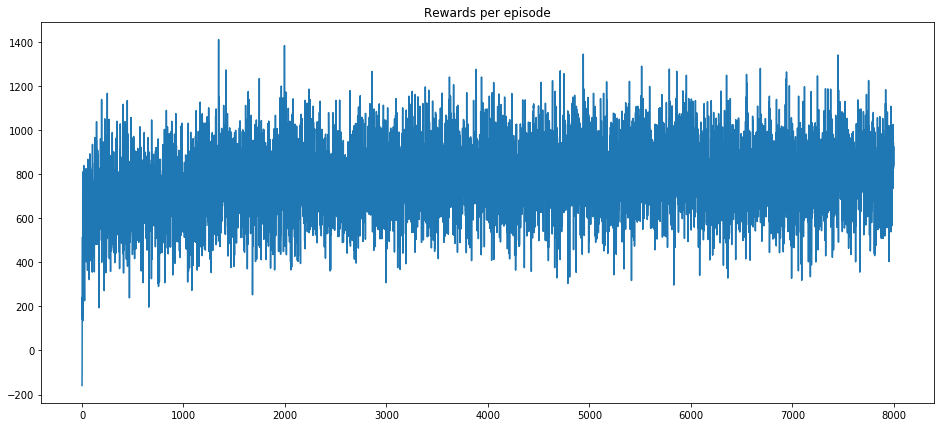

In [82]:
plt.figure(0, figsize=(16,7))
plt.title('Rewards per episode')
plt.plot(episodes,rewards_per_episode)


In [83]:
### DQN for episodes 5000
Episodes = 5000

In [84]:
learning_rate = 0.01
agent = DQNAgent(36,21,learning_rate)
rewards_per_episode, episodes = [], []

for episode in range(Episodes):

    # Write code here
   
    # Call all the initialised variables of the environment
    state_space = env.state_space
    action_space = env.action_space
    state = env.state_init
    print("Initial State is ",state)
    time = 0
    #Call the DQN agent
    terminal_state = False
    score = 0
    action = agent.get_action(env.state_encod_arch1(state),env)
    score += env.reward_func(state,action_space[action],Time_matrix)
    next_state,ride_time = env.next_state_func(state,action_space[action],Time_matrix)
    time += ride_time
    if time >= 24*30:
        agent.append_sample(env.state_encod_arch1(state),action,score,env.state_encod_arch1(next_state),True)
    else:
        agent.append_sample(env.state_encod_arch1(state),action,score,env.state_encod_arch1(next_state),False)
    loop = 0
    while not terminal_state:
        
        # Write your code here
        
        if time >= 24*30:
            terminal_state = True
            pass
        state = next_state
        # 1. Pick epsilon-greedy action from possible actions for the current state
        action = agent.get_action(env.state_encod_arch1(state),env)
        # 2. Evaluate your reward and next state
        reward_curr_ride = env.reward_func(state,action_space[action],Time_matrix)
        score+= reward_curr_ride
        next_state,ride_time = env.next_state_func(next_state,action_space[action],Time_matrix)
        time += ride_time
        # 3. Append the experience to the memory
        if time >= 24*30:
            agent.append_sample(env.state_encod_arch1(state),action,reward_curr_ride,env.state_encod_arch1(next_state),True)
        else:
            agent.append_sample(env.state_encod_arch1(state),action,reward_curr_ride,env.state_encod_arch1(next_state),False)
        # 4. Train the model by calling function agent.train_model
        agent.train_model(env)
        #print('Time elapsed {} and current loop {}'.format(time,loop))
        loop+= 1
        # 5. Keep a track of rewards, Q-values, loss
    
    rewards_per_episode.append(score)   
    episodes.append(episode)
    
    if agent.epsilon > agent.epsilon_min:
        agent.epsilon *= agent.epsilon_decay
# every episode:
    print("episode {0}, reward {1}, memory_length {2}, epsilon {3}, time {4}, rides {5}".format(episode,
                                                                         score,
                                                                         len(agent.memory),
                                                                         agent.epsilon,time,loop))
    # every few episodes:
        # Save the Q_value of the state, action pair we are tracking
    if ((episode + 1) % 5 == 0):
        agent.save_tracking_states()
    if episode % 1000 == 0:
        # store q-values of some prespecified state-action pairs
        # q_dict = agent.store_q_values()

        # save model weights
        agent.save(name="model_weights.h5")

Initial State is  [1, 13, 1]
episode 0, reward -332.0, memory_length 124, epsilon 0.0005, time 726.0, rides 123
Initial State is  [1, 13, 1]
episode 1, reward -201.0, memory_length 251, epsilon 0.0005, time 737.0, rides 126
Initial State is  [1, 13, 1]
episode 2, reward -225.0, memory_length 391, epsilon 0.0005, time 727.0, rides 139
Initial State is  [1, 13, 1]
episode 3, reward 172.0, memory_length 523, epsilon 0.0005, time 723.0, rides 131
Initial State is  [1, 13, 1]
episode 4, reward 441.0, memory_length 652, epsilon 0.0005, time 723.0, rides 128
Initial State is  [1, 13, 1]
episode 5, reward 59.0, memory_length 779, epsilon 0.0005, time 731.0, rides 126
Initial State is  [1, 13, 1]
episode 6, reward 400.0, memory_length 897, epsilon 0.0005, time 728.0, rides 117
Initial State is  [1, 13, 1]
episode 7, reward 358.0, memory_length 1028, epsilon 0.0005, time 733.0, rides 130
Initial State is  [1, 13, 1]
episode 8, reward 363.0, memory_length 1139, epsilon 0.0005, time 732.0, rides 1

episode 73, reward 729.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 128
Initial State is  [1, 13, 1]
episode 74, reward 862.0, memory_length 2000, epsilon 0.0005, time 737.0, rides 109
Initial State is  [1, 13, 1]
episode 75, reward 334.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 110
Initial State is  [1, 13, 1]
episode 76, reward 433.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 113
Initial State is  [1, 13, 1]
episode 77, reward 968.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 115
Initial State is  [1, 13, 1]
episode 78, reward 1066.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 119
Initial State is  [1, 13, 1]
episode 79, reward 572.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 136
Initial State is  [1, 13, 1]
episode 80, reward 542.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 125
Initial State is  [1, 13, 1]
episode 81, reward 880.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 117
Initial Sta

episode 146, reward 677.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 118
Initial State is  [1, 13, 1]
episode 147, reward 780.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 122
Initial State is  [1, 13, 1]
episode 148, reward 733.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 105
Initial State is  [1, 13, 1]
episode 149, reward 810.0, memory_length 2000, epsilon 0.0005, time 738.0, rides 122
Initial State is  [1, 13, 1]
episode 150, reward 512.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 109
Initial State is  [1, 13, 1]
episode 151, reward 765.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 119
Initial State is  [1, 13, 1]
episode 152, reward 560.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 131
Initial State is  [1, 13, 1]
episode 153, reward 511.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 127
Initial State is  [1, 13, 1]
episode 154, reward 784.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 117
Ini

episode 218, reward 640.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 129
Initial State is  [1, 13, 1]
episode 219, reward 809.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 134
Initial State is  [1, 13, 1]
episode 220, reward 764.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 123
Initial State is  [1, 13, 1]
episode 221, reward 743.0, memory_length 2000, epsilon 0.0005, time 740.0, rides 138
Initial State is  [1, 13, 1]
episode 222, reward 806.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 136
Initial State is  [1, 13, 1]
episode 223, reward 551.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 125
Initial State is  [1, 13, 1]
episode 224, reward 615.0, memory_length 2000, epsilon 0.0005, time 740.0, rides 124
Initial State is  [1, 13, 1]
episode 225, reward 600.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 129
Initial State is  [1, 13, 1]
episode 226, reward 915.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 119
Ini

episode 290, reward 837.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 117
Initial State is  [1, 13, 1]
episode 291, reward 614.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 120
Initial State is  [1, 13, 1]
episode 292, reward 1017.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 126
Initial State is  [1, 13, 1]
episode 293, reward 545.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 128
Initial State is  [1, 13, 1]
episode 294, reward 622.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 119
Initial State is  [1, 13, 1]
episode 295, reward 658.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 135
Initial State is  [1, 13, 1]
episode 296, reward 732.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 134
Initial State is  [1, 13, 1]
episode 297, reward 615.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 132
Initial State is  [1, 13, 1]
episode 298, reward 530.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 126
In

episode 362, reward 442.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 121
Initial State is  [1, 13, 1]
episode 363, reward 589.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 129
Initial State is  [1, 13, 1]
episode 364, reward 925.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 123
Initial State is  [1, 13, 1]
episode 365, reward 439.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 123
Initial State is  [1, 13, 1]
episode 366, reward 664.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 123
Initial State is  [1, 13, 1]
episode 367, reward 549.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 123
Initial State is  [1, 13, 1]
episode 368, reward 463.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 133
Initial State is  [1, 13, 1]
episode 369, reward 554.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 139
Initial State is  [1, 13, 1]
episode 370, reward 379.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 114
Ini

episode 434, reward 703.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 124
Initial State is  [1, 13, 1]
episode 435, reward 406.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 126
Initial State is  [1, 13, 1]
episode 436, reward 646.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 129
Initial State is  [1, 13, 1]
episode 437, reward 469.0, memory_length 2000, epsilon 0.0005, time 739.0, rides 124
Initial State is  [1, 13, 1]
episode 438, reward 592.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 129
Initial State is  [1, 13, 1]
episode 439, reward 752.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 136
Initial State is  [1, 13, 1]
episode 440, reward 932.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 132
Initial State is  [1, 13, 1]
episode 441, reward 702.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 137
Initial State is  [1, 13, 1]
episode 442, reward 413.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 124
Ini

episode 506, reward 526.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 123
Initial State is  [1, 13, 1]
episode 507, reward 330.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 129
Initial State is  [1, 13, 1]
episode 508, reward 698.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 131
Initial State is  [1, 13, 1]
episode 509, reward 567.0, memory_length 2000, epsilon 0.0005, time 747.0, rides 124
Initial State is  [1, 13, 1]
episode 510, reward 568.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 137
Initial State is  [1, 13, 1]
episode 511, reward 632.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 140
Initial State is  [1, 13, 1]
episode 512, reward 529.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 120
Initial State is  [1, 13, 1]
episode 513, reward 653.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 122
Initial State is  [1, 13, 1]
episode 514, reward 698.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 115
Ini

episode 578, reward 714.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 125
Initial State is  [1, 13, 1]
episode 579, reward 743.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 118
Initial State is  [1, 13, 1]
episode 580, reward 577.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 127
Initial State is  [1, 13, 1]
episode 581, reward 656.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 120
Initial State is  [1, 13, 1]
episode 582, reward 1044.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 120
Initial State is  [1, 13, 1]
episode 583, reward 788.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 118
Initial State is  [1, 13, 1]
episode 584, reward 653.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 114
Initial State is  [1, 13, 1]
episode 585, reward 957.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 125
Initial State is  [1, 13, 1]
episode 586, reward 610.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 121
In

episode 650, reward 764.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 127
Initial State is  [1, 13, 1]
episode 651, reward 567.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 125
Initial State is  [1, 13, 1]
episode 652, reward 700.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 136
Initial State is  [1, 13, 1]
episode 653, reward 979.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 122
Initial State is  [1, 13, 1]
episode 654, reward 725.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 120
Initial State is  [1, 13, 1]
episode 655, reward 765.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 129
Initial State is  [1, 13, 1]
episode 656, reward 562.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 124
Initial State is  [1, 13, 1]
episode 657, reward 848.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 127
Initial State is  [1, 13, 1]
episode 658, reward 596.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 118
Ini

episode 722, reward 668.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 127
Initial State is  [1, 13, 1]
episode 723, reward 723.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 132
Initial State is  [1, 13, 1]
episode 724, reward 695.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 122
Initial State is  [1, 13, 1]
episode 725, reward 709.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 118
Initial State is  [1, 13, 1]
episode 726, reward 771.0, memory_length 2000, epsilon 0.0005, time 739.0, rides 118
Initial State is  [1, 13, 1]
episode 727, reward 594.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 121
Initial State is  [1, 13, 1]
episode 728, reward 536.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 118
Initial State is  [1, 13, 1]
episode 729, reward 745.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 113
Initial State is  [1, 13, 1]
episode 730, reward 764.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 118
Ini

episode 794, reward 780.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 120
Initial State is  [1, 13, 1]
episode 795, reward 641.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 122
Initial State is  [1, 13, 1]
episode 796, reward 433.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 123
Initial State is  [1, 13, 1]
episode 797, reward 313.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 123
Initial State is  [1, 13, 1]
episode 798, reward 509.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 145
Initial State is  [1, 13, 1]
episode 799, reward 817.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 135
Initial State is  [1, 13, 1]
episode 800, reward 484.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 125
Initial State is  [1, 13, 1]
episode 801, reward 559.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 124
Initial State is  [1, 13, 1]
episode 802, reward 664.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 112
Ini

episode 866, reward 782.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 129
Initial State is  [1, 13, 1]
episode 867, reward 801.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 134
Initial State is  [1, 13, 1]
episode 868, reward 844.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 113
Initial State is  [1, 13, 1]
episode 869, reward 621.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 133
Initial State is  [1, 13, 1]
episode 870, reward 851.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 115
Initial State is  [1, 13, 1]
episode 871, reward 703.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 134
Initial State is  [1, 13, 1]
episode 872, reward 789.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 117
Initial State is  [1, 13, 1]
episode 873, reward 645.0, memory_length 2000, epsilon 0.0005, time 739.0, rides 122
Initial State is  [1, 13, 1]
episode 874, reward 570.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 123
Ini

episode 938, reward 551.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 110
Initial State is  [1, 13, 1]
episode 939, reward 546.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 125
Initial State is  [1, 13, 1]
episode 940, reward 783.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 122
Initial State is  [1, 13, 1]
episode 941, reward 665.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 119
Initial State is  [1, 13, 1]
episode 942, reward 582.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 121
Initial State is  [1, 13, 1]
episode 943, reward 863.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 132
Initial State is  [1, 13, 1]
episode 944, reward 899.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 122
Initial State is  [1, 13, 1]
episode 945, reward 754.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 120
Initial State is  [1, 13, 1]
episode 946, reward 633.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 134
Ini

episode 1010, reward 885.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 129
Initial State is  [1, 13, 1]
episode 1011, reward 733.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 133
Initial State is  [1, 13, 1]
episode 1012, reward 706.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 127
Initial State is  [1, 13, 1]
episode 1013, reward 717.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 130
Initial State is  [1, 13, 1]
episode 1014, reward 622.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 121
Initial State is  [1, 13, 1]
episode 1015, reward 519.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 131
Initial State is  [1, 13, 1]
episode 1016, reward 875.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 121
Initial State is  [1, 13, 1]
episode 1017, reward 679.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 123
Initial State is  [1, 13, 1]
episode 1018, reward 615.0, memory_length 2000, epsilon 0.0005, time 727.0, ride

episode 1082, reward 629.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 125
Initial State is  [1, 13, 1]
episode 1083, reward 661.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 131
Initial State is  [1, 13, 1]
episode 1084, reward 517.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 122
Initial State is  [1, 13, 1]
episode 1085, reward 604.0, memory_length 2000, epsilon 0.0005, time 738.0, rides 135
Initial State is  [1, 13, 1]
episode 1086, reward 707.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 132
Initial State is  [1, 13, 1]
episode 1087, reward 748.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 124
Initial State is  [1, 13, 1]
episode 1088, reward 857.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 133
Initial State is  [1, 13, 1]
episode 1089, reward 722.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 112
Initial State is  [1, 13, 1]
episode 1090, reward 798.0, memory_length 2000, epsilon 0.0005, time 728.0, ride

episode 1154, reward 665.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 125
Initial State is  [1, 13, 1]
episode 1155, reward 552.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 123
Initial State is  [1, 13, 1]
episode 1156, reward 544.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 122
Initial State is  [1, 13, 1]
episode 1157, reward 696.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 121
Initial State is  [1, 13, 1]
episode 1158, reward 920.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 129
Initial State is  [1, 13, 1]
episode 1159, reward 728.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 134
Initial State is  [1, 13, 1]
episode 1160, reward 453.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 130
Initial State is  [1, 13, 1]
episode 1161, reward 426.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 119
Initial State is  [1, 13, 1]
episode 1162, reward 534.0, memory_length 2000, epsilon 0.0005, time 728.0, ride

episode 1226, reward 849.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 134
Initial State is  [1, 13, 1]
episode 1227, reward 876.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 140
Initial State is  [1, 13, 1]
episode 1228, reward 569.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 134
Initial State is  [1, 13, 1]
episode 1229, reward 704.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 128
Initial State is  [1, 13, 1]
episode 1230, reward 806.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 130
Initial State is  [1, 13, 1]
episode 1231, reward 834.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 141
Initial State is  [1, 13, 1]
episode 1232, reward 689.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 138
Initial State is  [1, 13, 1]
episode 1233, reward 1014.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 123
Initial State is  [1, 13, 1]
episode 1234, reward 673.0, memory_length 2000, epsilon 0.0005, time 726.0, rid

episode 1298, reward 612.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 132
Initial State is  [1, 13, 1]
episode 1299, reward 760.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 117
Initial State is  [1, 13, 1]
episode 1300, reward 346.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 128
Initial State is  [1, 13, 1]
episode 1301, reward 487.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 131
Initial State is  [1, 13, 1]
episode 1302, reward 664.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 132
Initial State is  [1, 13, 1]
episode 1303, reward 766.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 122
Initial State is  [1, 13, 1]
episode 1304, reward 696.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 130
Initial State is  [1, 13, 1]
episode 1305, reward 789.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 125
Initial State is  [1, 13, 1]
episode 1306, reward 499.0, memory_length 2000, epsilon 0.0005, time 724.0, ride

episode 1370, reward 671.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 129
Initial State is  [1, 13, 1]
episode 1371, reward 625.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 118
Initial State is  [1, 13, 1]
episode 1372, reward 674.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 124
Initial State is  [1, 13, 1]
episode 1373, reward 667.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 131
Initial State is  [1, 13, 1]
episode 1374, reward 655.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 129
Initial State is  [1, 13, 1]
episode 1375, reward 601.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 133
Initial State is  [1, 13, 1]
episode 1376, reward 769.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 127
Initial State is  [1, 13, 1]
episode 1377, reward 702.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 121
Initial State is  [1, 13, 1]
episode 1378, reward 843.0, memory_length 2000, epsilon 0.0005, time 728.0, ride

episode 1442, reward 744.0, memory_length 2000, epsilon 0.0005, time 721.0, rides 123
Initial State is  [1, 13, 1]
episode 1443, reward 680.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 123
Initial State is  [1, 13, 1]
episode 1444, reward 528.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 115
Initial State is  [1, 13, 1]
episode 1445, reward 550.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 123
Initial State is  [1, 13, 1]
episode 1446, reward 694.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 124
Initial State is  [1, 13, 1]
episode 1447, reward 703.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 119
Initial State is  [1, 13, 1]
episode 1448, reward 688.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 111
Initial State is  [1, 13, 1]
episode 1449, reward 608.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 116
Initial State is  [1, 13, 1]
episode 1450, reward 648.0, memory_length 2000, epsilon 0.0005, time 729.0, ride

episode 1514, reward 553.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 129
Initial State is  [1, 13, 1]
episode 1515, reward 668.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 131
Initial State is  [1, 13, 1]
episode 1516, reward 451.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 121
Initial State is  [1, 13, 1]
episode 1517, reward 672.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 136
Initial State is  [1, 13, 1]
episode 1518, reward 660.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 130
Initial State is  [1, 13, 1]
episode 1519, reward 906.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 124
Initial State is  [1, 13, 1]
episode 1520, reward 694.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 130
Initial State is  [1, 13, 1]
episode 1521, reward 915.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 116
Initial State is  [1, 13, 1]
episode 1522, reward 796.0, memory_length 2000, epsilon 0.0005, time 730.0, ride

episode 1586, reward 590.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 120
Initial State is  [1, 13, 1]
episode 1587, reward 691.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 129
Initial State is  [1, 13, 1]
episode 1588, reward 974.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 139
Initial State is  [1, 13, 1]
episode 1589, reward 975.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 130
Initial State is  [1, 13, 1]
episode 1590, reward 673.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 121
Initial State is  [1, 13, 1]
episode 1591, reward 706.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 130
Initial State is  [1, 13, 1]
episode 1592, reward 516.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 126
Initial State is  [1, 13, 1]
episode 1593, reward 906.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 121
Initial State is  [1, 13, 1]
episode 1594, reward 555.0, memory_length 2000, epsilon 0.0005, time 736.0, ride

episode 1658, reward 673.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 114
Initial State is  [1, 13, 1]
episode 1659, reward 870.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 131
Initial State is  [1, 13, 1]
episode 1660, reward 526.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 118
Initial State is  [1, 13, 1]
episode 1661, reward 654.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 127
Initial State is  [1, 13, 1]
episode 1662, reward 669.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 120
Initial State is  [1, 13, 1]
episode 1663, reward 702.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 126
Initial State is  [1, 13, 1]
episode 1664, reward 777.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 131
Initial State is  [1, 13, 1]
episode 1665, reward 556.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 126
Initial State is  [1, 13, 1]
episode 1666, reward 824.0, memory_length 2000, epsilon 0.0005, time 727.0, ride

episode 1730, reward 942.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 147
Initial State is  [1, 13, 1]
episode 1731, reward 572.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 119
Initial State is  [1, 13, 1]
episode 1732, reward 706.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 122
Initial State is  [1, 13, 1]
episode 1733, reward 728.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 141
Initial State is  [1, 13, 1]
episode 1734, reward 530.0, memory_length 2000, epsilon 0.0005, time 737.0, rides 125
Initial State is  [1, 13, 1]
episode 1735, reward 701.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 126
Initial State is  [1, 13, 1]
episode 1736, reward 800.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 131
Initial State is  [1, 13, 1]
episode 1737, reward 950.0, memory_length 2000, epsilon 0.0005, time 739.0, rides 139
Initial State is  [1, 13, 1]
episode 1738, reward 782.0, memory_length 2000, epsilon 0.0005, time 730.0, ride

episode 1802, reward 867.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 119
Initial State is  [1, 13, 1]
episode 1803, reward 632.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 121
Initial State is  [1, 13, 1]
episode 1804, reward 636.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 132
Initial State is  [1, 13, 1]
episode 1805, reward 876.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 133
Initial State is  [1, 13, 1]
episode 1806, reward 692.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 140
Initial State is  [1, 13, 1]
episode 1807, reward 1062.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 128
Initial State is  [1, 13, 1]
episode 1808, reward 537.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 125
Initial State is  [1, 13, 1]
episode 1809, reward 536.0, memory_length 2000, epsilon 0.0005, time 742.0, rides 121
Initial State is  [1, 13, 1]
episode 1810, reward 895.0, memory_length 2000, epsilon 0.0005, time 732.0, rid

episode 1874, reward 745.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 124
Initial State is  [1, 13, 1]
episode 1875, reward 833.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 127
Initial State is  [1, 13, 1]
episode 1876, reward 594.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 137
Initial State is  [1, 13, 1]
episode 1877, reward 596.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 124
Initial State is  [1, 13, 1]
episode 1878, reward 892.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 128
Initial State is  [1, 13, 1]
episode 1879, reward 679.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 138
Initial State is  [1, 13, 1]
episode 1880, reward 338.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 131
Initial State is  [1, 13, 1]
episode 1881, reward 846.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 116
Initial State is  [1, 13, 1]
episode 1882, reward 885.0, memory_length 2000, epsilon 0.0005, time 728.0, ride

episode 1946, reward 592.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 132
Initial State is  [1, 13, 1]
episode 1947, reward 521.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 116
Initial State is  [1, 13, 1]
episode 1948, reward 623.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 119
Initial State is  [1, 13, 1]
episode 1949, reward 722.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 131
Initial State is  [1, 13, 1]
episode 1950, reward 709.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 124
Initial State is  [1, 13, 1]
episode 1951, reward 816.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 129
Initial State is  [1, 13, 1]
episode 1952, reward 744.0, memory_length 2000, epsilon 0.0005, time 721.0, rides 119
Initial State is  [1, 13, 1]
episode 1953, reward 835.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 130
Initial State is  [1, 13, 1]
episode 1954, reward 593.0, memory_length 2000, epsilon 0.0005, time 734.0, ride

episode 2018, reward 799.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 124
Initial State is  [1, 13, 1]
episode 2019, reward 668.0, memory_length 2000, epsilon 0.0005, time 737.0, rides 134
Initial State is  [1, 13, 1]
episode 2020, reward 962.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 143
Initial State is  [1, 13, 1]
episode 2021, reward 859.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 119
Initial State is  [1, 13, 1]
episode 2022, reward 892.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 137
Initial State is  [1, 13, 1]
episode 2023, reward 930.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 126
Initial State is  [1, 13, 1]
episode 2024, reward 562.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 137
Initial State is  [1, 13, 1]
episode 2025, reward 392.0, memory_length 2000, epsilon 0.0005, time 737.0, rides 128
Initial State is  [1, 13, 1]
episode 2026, reward 507.0, memory_length 2000, epsilon 0.0005, time 726.0, ride

episode 2090, reward 921.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 122
Initial State is  [1, 13, 1]
episode 2091, reward 663.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 134
Initial State is  [1, 13, 1]
episode 2092, reward 657.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 120
Initial State is  [1, 13, 1]
episode 2093, reward 751.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 152
Initial State is  [1, 13, 1]
episode 2094, reward 825.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 126
Initial State is  [1, 13, 1]
episode 2095, reward 546.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 139
Initial State is  [1, 13, 1]
episode 2096, reward 378.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 135
Initial State is  [1, 13, 1]
episode 2097, reward 852.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 128
Initial State is  [1, 13, 1]
episode 2098, reward 705.0, memory_length 2000, epsilon 0.0005, time 723.0, ride

episode 2162, reward 972.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 115
Initial State is  [1, 13, 1]
episode 2163, reward 982.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 119
Initial State is  [1, 13, 1]
episode 2164, reward 837.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 122
Initial State is  [1, 13, 1]
episode 2165, reward 845.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 134
Initial State is  [1, 13, 1]
episode 2166, reward 818.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 119
Initial State is  [1, 13, 1]
episode 2167, reward 637.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 119
Initial State is  [1, 13, 1]
episode 2168, reward 837.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 109
Initial State is  [1, 13, 1]
episode 2169, reward 355.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 120
Initial State is  [1, 13, 1]
episode 2170, reward 914.0, memory_length 2000, epsilon 0.0005, time 728.0, ride

episode 2234, reward 661.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 130
Initial State is  [1, 13, 1]
episode 2235, reward 742.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 124
Initial State is  [1, 13, 1]
episode 2236, reward 614.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 134
Initial State is  [1, 13, 1]
episode 2237, reward 831.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 123
Initial State is  [1, 13, 1]
episode 2238, reward 740.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 118
Initial State is  [1, 13, 1]
episode 2239, reward 740.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 131
Initial State is  [1, 13, 1]
episode 2240, reward 1065.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 125
Initial State is  [1, 13, 1]
episode 2241, reward 861.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 126
Initial State is  [1, 13, 1]
episode 2242, reward 727.0, memory_length 2000, epsilon 0.0005, time 726.0, rid

episode 2306, reward 409.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 128
Initial State is  [1, 13, 1]
episode 2307, reward 791.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 130
Initial State is  [1, 13, 1]
episode 2308, reward 633.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 144
Initial State is  [1, 13, 1]
episode 2309, reward 804.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 121
Initial State is  [1, 13, 1]
episode 2310, reward 449.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 131
Initial State is  [1, 13, 1]
episode 2311, reward 557.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 131
Initial State is  [1, 13, 1]
episode 2312, reward 341.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 123
Initial State is  [1, 13, 1]
episode 2313, reward 809.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 134
Initial State is  [1, 13, 1]
episode 2314, reward 606.0, memory_length 2000, epsilon 0.0005, time 727.0, ride

episode 2378, reward 634.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 118
Initial State is  [1, 13, 1]
episode 2379, reward 499.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 129
Initial State is  [1, 13, 1]
episode 2380, reward 664.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 121
Initial State is  [1, 13, 1]
episode 2381, reward 817.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 109
Initial State is  [1, 13, 1]
episode 2382, reward 671.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 124
Initial State is  [1, 13, 1]
episode 2383, reward 595.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 124
Initial State is  [1, 13, 1]
episode 2384, reward 749.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 127
Initial State is  [1, 13, 1]
episode 2385, reward 514.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 122
Initial State is  [1, 13, 1]
episode 2386, reward 722.0, memory_length 2000, epsilon 0.0005, time 731.0, ride

episode 2450, reward 708.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 123
Initial State is  [1, 13, 1]
episode 2451, reward 833.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 122
Initial State is  [1, 13, 1]
episode 2452, reward 663.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 128
Initial State is  [1, 13, 1]
episode 2453, reward 627.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 148
Initial State is  [1, 13, 1]
episode 2454, reward 685.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 116
Initial State is  [1, 13, 1]
episode 2455, reward 591.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 119
Initial State is  [1, 13, 1]
episode 2456, reward 713.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 120
Initial State is  [1, 13, 1]
episode 2457, reward 675.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 111
Initial State is  [1, 13, 1]
episode 2458, reward 1098.0, memory_length 2000, epsilon 0.0005, time 726.0, rid

episode 2522, reward 619.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 127
Initial State is  [1, 13, 1]
episode 2523, reward 695.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 143
Initial State is  [1, 13, 1]
episode 2524, reward 676.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 133
Initial State is  [1, 13, 1]
episode 2525, reward 672.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 126
Initial State is  [1, 13, 1]
episode 2526, reward 717.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 130
Initial State is  [1, 13, 1]
episode 2527, reward 984.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 135
Initial State is  [1, 13, 1]
episode 2528, reward 743.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 131
Initial State is  [1, 13, 1]
episode 2529, reward 767.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 124
Initial State is  [1, 13, 1]
episode 2530, reward 467.0, memory_length 2000, epsilon 0.0005, time 729.0, ride

episode 2594, reward 472.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 126
Initial State is  [1, 13, 1]
episode 2595, reward 975.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 118
Initial State is  [1, 13, 1]
episode 2596, reward 480.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 133
Initial State is  [1, 13, 1]
episode 2597, reward 812.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 132
Initial State is  [1, 13, 1]
episode 2598, reward 429.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 110
Initial State is  [1, 13, 1]
episode 2599, reward 731.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 127
Initial State is  [1, 13, 1]
episode 2600, reward 658.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 138
Initial State is  [1, 13, 1]
episode 2601, reward 722.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 111
Initial State is  [1, 13, 1]
episode 2602, reward 650.0, memory_length 2000, epsilon 0.0005, time 725.0, ride

episode 2666, reward 863.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 133
Initial State is  [1, 13, 1]
episode 2667, reward 650.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 116
Initial State is  [1, 13, 1]
episode 2668, reward 758.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 130
Initial State is  [1, 13, 1]
episode 2669, reward 742.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 138
Initial State is  [1, 13, 1]
episode 2670, reward 785.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 113
Initial State is  [1, 13, 1]
episode 2671, reward 721.0, memory_length 2000, epsilon 0.0005, time 739.0, rides 122
Initial State is  [1, 13, 1]
episode 2672, reward 659.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 136
Initial State is  [1, 13, 1]
episode 2673, reward 642.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 124
Initial State is  [1, 13, 1]
episode 2674, reward 1026.0, memory_length 2000, epsilon 0.0005, time 727.0, rid

episode 2738, reward 820.0, memory_length 2000, epsilon 0.0005, time 742.0, rides 125
Initial State is  [1, 13, 1]
episode 2739, reward 709.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 119
Initial State is  [1, 13, 1]
episode 2740, reward 767.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 130
Initial State is  [1, 13, 1]
episode 2741, reward 689.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 124
Initial State is  [1, 13, 1]
episode 2742, reward 506.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 135
Initial State is  [1, 13, 1]
episode 2743, reward 652.0, memory_length 2000, epsilon 0.0005, time 742.0, rides 134
Initial State is  [1, 13, 1]
episode 2744, reward 648.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 123
Initial State is  [1, 13, 1]
episode 2745, reward 875.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 122
Initial State is  [1, 13, 1]
episode 2746, reward 601.0, memory_length 2000, epsilon 0.0005, time 725.0, ride

episode 2810, reward 253.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 136
Initial State is  [1, 13, 1]
episode 2811, reward 433.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 118
Initial State is  [1, 13, 1]
episode 2812, reward 706.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 131
Initial State is  [1, 13, 1]
episode 2813, reward 561.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 138
Initial State is  [1, 13, 1]
episode 2814, reward 598.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 131
Initial State is  [1, 13, 1]
episode 2815, reward 696.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 126
Initial State is  [1, 13, 1]
episode 2816, reward 520.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 128
Initial State is  [1, 13, 1]
episode 2817, reward 695.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 125
Initial State is  [1, 13, 1]
episode 2818, reward 891.0, memory_length 2000, epsilon 0.0005, time 731.0, ride

episode 2882, reward 529.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 134
Initial State is  [1, 13, 1]
episode 2883, reward 757.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 126
Initial State is  [1, 13, 1]
episode 2884, reward 1013.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 131
Initial State is  [1, 13, 1]
episode 2885, reward 819.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 136
Initial State is  [1, 13, 1]
episode 2886, reward 783.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 135
Initial State is  [1, 13, 1]
episode 2887, reward 497.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 123
Initial State is  [1, 13, 1]
episode 2888, reward 726.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 121
Initial State is  [1, 13, 1]
episode 2889, reward 774.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 139
Initial State is  [1, 13, 1]
episode 2890, reward 542.0, memory_length 2000, epsilon 0.0005, time 722.0, rid

episode 2954, reward 780.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 130
Initial State is  [1, 13, 1]
episode 2955, reward 754.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 145
Initial State is  [1, 13, 1]
episode 2956, reward 606.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 130
Initial State is  [1, 13, 1]
episode 2957, reward 767.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 124
Initial State is  [1, 13, 1]
episode 2958, reward 610.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 123
Initial State is  [1, 13, 1]
episode 2959, reward 413.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 127
Initial State is  [1, 13, 1]
episode 2960, reward 531.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 148
Initial State is  [1, 13, 1]
episode 2961, reward 788.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 138
Initial State is  [1, 13, 1]
episode 2962, reward 615.0, memory_length 2000, epsilon 0.0005, time 730.0, ride

episode 3026, reward 663.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 128
Initial State is  [1, 13, 1]
episode 3027, reward 682.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 126
Initial State is  [1, 13, 1]
episode 3028, reward 694.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 126
Initial State is  [1, 13, 1]
episode 3029, reward 640.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 135
Initial State is  [1, 13, 1]
episode 3030, reward 605.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 133
Initial State is  [1, 13, 1]
episode 3031, reward 1022.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 131
Initial State is  [1, 13, 1]
episode 3032, reward 1059.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 143
Initial State is  [1, 13, 1]
episode 3033, reward 739.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 133
Initial State is  [1, 13, 1]
episode 3034, reward 706.0, memory_length 2000, epsilon 0.0005, time 734.0, ri

episode 3098, reward 772.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 122
Initial State is  [1, 13, 1]
episode 3099, reward 1045.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 135
Initial State is  [1, 13, 1]
episode 3100, reward 632.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 126
Initial State is  [1, 13, 1]
episode 3101, reward 762.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 121
Initial State is  [1, 13, 1]
episode 3102, reward 826.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 121
Initial State is  [1, 13, 1]
episode 3103, reward 736.0, memory_length 2000, epsilon 0.0005, time 737.0, rides 127
Initial State is  [1, 13, 1]
episode 3104, reward 996.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 124
Initial State is  [1, 13, 1]
episode 3105, reward 655.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 127
Initial State is  [1, 13, 1]
episode 3106, reward 744.0, memory_length 2000, epsilon 0.0005, time 735.0, rid

episode 3170, reward 676.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 132
Initial State is  [1, 13, 1]
episode 3171, reward 546.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 132
Initial State is  [1, 13, 1]
episode 3172, reward 429.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 122
Initial State is  [1, 13, 1]
episode 3173, reward 643.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 127
Initial State is  [1, 13, 1]
episode 3174, reward 738.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 121
Initial State is  [1, 13, 1]
episode 3175, reward 851.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 122
Initial State is  [1, 13, 1]
episode 3176, reward 639.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 121
Initial State is  [1, 13, 1]
episode 3177, reward 916.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 121
Initial State is  [1, 13, 1]
episode 3178, reward 607.0, memory_length 2000, epsilon 0.0005, time 732.0, ride

episode 3242, reward 832.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 124
Initial State is  [1, 13, 1]
episode 3243, reward 647.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 120
Initial State is  [1, 13, 1]
episode 3244, reward 784.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 117
Initial State is  [1, 13, 1]
episode 3245, reward 780.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 123
Initial State is  [1, 13, 1]
episode 3246, reward 453.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 134
Initial State is  [1, 13, 1]
episode 3247, reward 767.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 130
Initial State is  [1, 13, 1]
episode 3248, reward 571.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 126
Initial State is  [1, 13, 1]
episode 3249, reward 782.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 125
Initial State is  [1, 13, 1]
episode 3250, reward 580.0, memory_length 2000, epsilon 0.0005, time 734.0, ride

episode 3314, reward 710.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 125
Initial State is  [1, 13, 1]
episode 3315, reward 813.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 131
Initial State is  [1, 13, 1]
episode 3316, reward 815.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 131
Initial State is  [1, 13, 1]
episode 3317, reward 614.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 140
Initial State is  [1, 13, 1]
episode 3318, reward 667.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 134
Initial State is  [1, 13, 1]
episode 3319, reward 834.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 122
Initial State is  [1, 13, 1]
episode 3320, reward 720.0, memory_length 2000, epsilon 0.0005, time 737.0, rides 114
Initial State is  [1, 13, 1]
episode 3321, reward 519.0, memory_length 2000, epsilon 0.0005, time 721.0, rides 132
Initial State is  [1, 13, 1]
episode 3322, reward 777.0, memory_length 2000, epsilon 0.0005, time 735.0, ride

episode 3386, reward 400.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 128
Initial State is  [1, 13, 1]
episode 3387, reward 614.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 125
Initial State is  [1, 13, 1]
episode 3388, reward 917.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 126
Initial State is  [1, 13, 1]
episode 3389, reward 661.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 127
Initial State is  [1, 13, 1]
episode 3390, reward 608.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 124
Initial State is  [1, 13, 1]
episode 3391, reward 758.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 121
Initial State is  [1, 13, 1]
episode 3392, reward 859.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 116
Initial State is  [1, 13, 1]
episode 3393, reward 729.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 129
Initial State is  [1, 13, 1]
episode 3394, reward 968.0, memory_length 2000, epsilon 0.0005, time 737.0, ride

episode 3458, reward 596.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 125
Initial State is  [1, 13, 1]
episode 3459, reward 650.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 112
Initial State is  [1, 13, 1]
episode 3460, reward 558.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 116
Initial State is  [1, 13, 1]
episode 3461, reward 981.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 121
Initial State is  [1, 13, 1]
episode 3462, reward 753.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 121
Initial State is  [1, 13, 1]
episode 3463, reward 742.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 134
Initial State is  [1, 13, 1]
episode 3464, reward 897.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 120
Initial State is  [1, 13, 1]
episode 3465, reward 376.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 119
Initial State is  [1, 13, 1]
episode 3466, reward 620.0, memory_length 2000, epsilon 0.0005, time 722.0, ride

episode 3530, reward 922.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 127
Initial State is  [1, 13, 1]
episode 3531, reward 941.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 124
Initial State is  [1, 13, 1]
episode 3532, reward 858.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 139
Initial State is  [1, 13, 1]
episode 3533, reward 674.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 122
Initial State is  [1, 13, 1]
episode 3534, reward 755.0, memory_length 2000, epsilon 0.0005, time 737.0, rides 123
Initial State is  [1, 13, 1]
episode 3535, reward 530.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 118
Initial State is  [1, 13, 1]
episode 3536, reward 655.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 124
Initial State is  [1, 13, 1]
episode 3537, reward 593.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 118
Initial State is  [1, 13, 1]
episode 3538, reward 645.0, memory_length 2000, epsilon 0.0005, time 732.0, ride

episode 3602, reward 579.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 137
Initial State is  [1, 13, 1]
episode 3603, reward 482.0, memory_length 2000, epsilon 0.0005, time 740.0, rides 124
Initial State is  [1, 13, 1]
episode 3604, reward 675.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 124
Initial State is  [1, 13, 1]
episode 3605, reward 564.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 129
Initial State is  [1, 13, 1]
episode 3606, reward 943.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 134
Initial State is  [1, 13, 1]
episode 3607, reward 809.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 126
Initial State is  [1, 13, 1]
episode 3608, reward 1163.0, memory_length 2000, epsilon 0.0005, time 737.0, rides 131
Initial State is  [1, 13, 1]
episode 3609, reward 654.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 132
Initial State is  [1, 13, 1]
episode 3610, reward 855.0, memory_length 2000, epsilon 0.0005, time 732.0, rid

episode 3674, reward 646.0, memory_length 2000, epsilon 0.0005, time 721.0, rides 133
Initial State is  [1, 13, 1]
episode 3675, reward 607.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 112
Initial State is  [1, 13, 1]
episode 3676, reward 831.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 125
Initial State is  [1, 13, 1]
episode 3677, reward 741.0, memory_length 2000, epsilon 0.0005, time 739.0, rides 112
Initial State is  [1, 13, 1]
episode 3678, reward 742.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 138
Initial State is  [1, 13, 1]
episode 3679, reward 861.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 124
Initial State is  [1, 13, 1]
episode 3680, reward 682.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 116
Initial State is  [1, 13, 1]
episode 3681, reward 656.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 133
Initial State is  [1, 13, 1]
episode 3682, reward 757.0, memory_length 2000, epsilon 0.0005, time 739.0, ride

episode 3746, reward 645.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 121
Initial State is  [1, 13, 1]
episode 3747, reward 839.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 125
Initial State is  [1, 13, 1]
episode 3748, reward 784.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 129
Initial State is  [1, 13, 1]
episode 3749, reward 990.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 123
Initial State is  [1, 13, 1]
episode 3750, reward 546.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 122
Initial State is  [1, 13, 1]
episode 3751, reward 753.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 131
Initial State is  [1, 13, 1]
episode 3752, reward 613.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 140
Initial State is  [1, 13, 1]
episode 3753, reward 736.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 134
Initial State is  [1, 13, 1]
episode 3754, reward 727.0, memory_length 2000, epsilon 0.0005, time 724.0, ride

episode 3818, reward 831.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 122
Initial State is  [1, 13, 1]
episode 3819, reward 491.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 128
Initial State is  [1, 13, 1]
episode 3820, reward 492.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 128
Initial State is  [1, 13, 1]
episode 3821, reward 542.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 133
Initial State is  [1, 13, 1]
episode 3822, reward 703.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 132
Initial State is  [1, 13, 1]
episode 3823, reward 908.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 127
Initial State is  [1, 13, 1]
episode 3824, reward 599.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 131
Initial State is  [1, 13, 1]
episode 3825, reward 976.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 127
Initial State is  [1, 13, 1]
episode 3826, reward 713.0, memory_length 2000, epsilon 0.0005, time 737.0, ride

episode 3890, reward 614.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 130
Initial State is  [1, 13, 1]
episode 3891, reward 798.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 133
Initial State is  [1, 13, 1]
episode 3892, reward 957.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 124
Initial State is  [1, 13, 1]
episode 3893, reward 790.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 134
Initial State is  [1, 13, 1]
episode 3894, reward 787.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 125
Initial State is  [1, 13, 1]
episode 3895, reward 678.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 127
Initial State is  [1, 13, 1]
episode 3896, reward 560.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 127
Initial State is  [1, 13, 1]
episode 3897, reward 637.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 137
Initial State is  [1, 13, 1]
episode 3898, reward 797.0, memory_length 2000, epsilon 0.0005, time 732.0, ride

episode 3962, reward 546.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 110
Initial State is  [1, 13, 1]
episode 3963, reward 618.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 120
Initial State is  [1, 13, 1]
episode 3964, reward 695.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 122
Initial State is  [1, 13, 1]
episode 3965, reward 688.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 124
Initial State is  [1, 13, 1]
episode 3966, reward 761.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 119
Initial State is  [1, 13, 1]
episode 3967, reward 535.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 132
Initial State is  [1, 13, 1]
episode 3968, reward 795.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 134
Initial State is  [1, 13, 1]
episode 3969, reward 805.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 128
Initial State is  [1, 13, 1]
episode 3970, reward 718.0, memory_length 2000, epsilon 0.0005, time 728.0, ride

episode 4034, reward 648.0, memory_length 2000, epsilon 0.0005, time 739.0, rides 132
Initial State is  [1, 13, 1]
episode 4035, reward 677.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 122
Initial State is  [1, 13, 1]
episode 4036, reward 616.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 117
Initial State is  [1, 13, 1]
episode 4037, reward 773.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 123
Initial State is  [1, 13, 1]
episode 4038, reward 733.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 114
Initial State is  [1, 13, 1]
episode 4039, reward 787.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 130
Initial State is  [1, 13, 1]
episode 4040, reward 617.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 118
Initial State is  [1, 13, 1]
episode 4041, reward 609.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 131
Initial State is  [1, 13, 1]
episode 4042, reward 803.0, memory_length 2000, epsilon 0.0005, time 731.0, ride

episode 4106, reward 516.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 139
Initial State is  [1, 13, 1]
episode 4107, reward 539.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 134
Initial State is  [1, 13, 1]
episode 4108, reward 814.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 122
Initial State is  [1, 13, 1]
episode 4109, reward 506.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 131
Initial State is  [1, 13, 1]
episode 4110, reward 711.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 127
Initial State is  [1, 13, 1]
episode 4111, reward 684.0, memory_length 2000, epsilon 0.0005, time 737.0, rides 139
Initial State is  [1, 13, 1]
episode 4112, reward 759.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 135
Initial State is  [1, 13, 1]
episode 4113, reward 855.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 121
Initial State is  [1, 13, 1]
episode 4114, reward 838.0, memory_length 2000, epsilon 0.0005, time 731.0, ride

episode 4178, reward 768.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 135
Initial State is  [1, 13, 1]
episode 4179, reward 727.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 120
Initial State is  [1, 13, 1]
episode 4180, reward 687.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 125
Initial State is  [1, 13, 1]
episode 4181, reward 927.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 127
Initial State is  [1, 13, 1]
episode 4182, reward 757.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 148
Initial State is  [1, 13, 1]
episode 4183, reward 816.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 127
Initial State is  [1, 13, 1]
episode 4184, reward 563.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 141
Initial State is  [1, 13, 1]
episode 4185, reward 684.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 126
Initial State is  [1, 13, 1]
episode 4186, reward 693.0, memory_length 2000, epsilon 0.0005, time 738.0, ride

episode 4250, reward 491.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 121
Initial State is  [1, 13, 1]
episode 4251, reward 758.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 132
Initial State is  [1, 13, 1]
episode 4252, reward 712.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 116
Initial State is  [1, 13, 1]
episode 4253, reward 795.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 131
Initial State is  [1, 13, 1]
episode 4254, reward 649.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 130
Initial State is  [1, 13, 1]
episode 4255, reward 643.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 125
Initial State is  [1, 13, 1]
episode 4256, reward 831.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 129
Initial State is  [1, 13, 1]
episode 4257, reward 679.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 111
Initial State is  [1, 13, 1]
episode 4258, reward 813.0, memory_length 2000, epsilon 0.0005, time 727.0, ride

episode 4322, reward 679.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 131
Initial State is  [1, 13, 1]
episode 4323, reward 844.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 126
Initial State is  [1, 13, 1]
episode 4324, reward 822.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 132
Initial State is  [1, 13, 1]
episode 4325, reward 615.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 127
Initial State is  [1, 13, 1]
episode 4326, reward 729.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 137
Initial State is  [1, 13, 1]
episode 4327, reward 964.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 126
Initial State is  [1, 13, 1]
episode 4328, reward 900.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 124
Initial State is  [1, 13, 1]
episode 4329, reward 941.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 134
Initial State is  [1, 13, 1]
episode 4330, reward 1028.0, memory_length 2000, epsilon 0.0005, time 727.0, rid

episode 4394, reward 780.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 127
Initial State is  [1, 13, 1]
episode 4395, reward 933.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 110
Initial State is  [1, 13, 1]
episode 4396, reward 610.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 112
Initial State is  [1, 13, 1]
episode 4397, reward 733.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 116
Initial State is  [1, 13, 1]
episode 4398, reward 544.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 125
Initial State is  [1, 13, 1]
episode 4399, reward 468.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 129
Initial State is  [1, 13, 1]
episode 4400, reward 789.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 123
Initial State is  [1, 13, 1]
episode 4401, reward 382.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 124
Initial State is  [1, 13, 1]
episode 4402, reward 859.0, memory_length 2000, epsilon 0.0005, time 740.0, ride

episode 4466, reward 1036.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 129
Initial State is  [1, 13, 1]
episode 4467, reward 761.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 121
Initial State is  [1, 13, 1]
episode 4468, reward 1057.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 133
Initial State is  [1, 13, 1]
episode 4469, reward 517.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 126
Initial State is  [1, 13, 1]
episode 4470, reward 439.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 124
Initial State is  [1, 13, 1]
episode 4471, reward 799.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 135
Initial State is  [1, 13, 1]
episode 4472, reward 586.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 118
Initial State is  [1, 13, 1]
episode 4473, reward 667.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 130
Initial State is  [1, 13, 1]
episode 4474, reward 885.0, memory_length 2000, epsilon 0.0005, time 728.0, ri

episode 4538, reward 530.0, memory_length 2000, epsilon 0.0005, time 737.0, rides 120
Initial State is  [1, 13, 1]
episode 4539, reward 761.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 139
Initial State is  [1, 13, 1]
episode 4540, reward 725.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 118
Initial State is  [1, 13, 1]
episode 4541, reward 751.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 143
Initial State is  [1, 13, 1]
episode 4542, reward 782.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 116
Initial State is  [1, 13, 1]
episode 4543, reward 884.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 137
Initial State is  [1, 13, 1]
episode 4544, reward 899.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 135
Initial State is  [1, 13, 1]
episode 4545, reward 887.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 114
Initial State is  [1, 13, 1]
episode 4546, reward 839.0, memory_length 2000, epsilon 0.0005, time 724.0, ride

episode 4610, reward 604.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 122
Initial State is  [1, 13, 1]
episode 4611, reward 959.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 117
Initial State is  [1, 13, 1]
episode 4612, reward 819.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 141
Initial State is  [1, 13, 1]
episode 4613, reward 657.0, memory_length 2000, epsilon 0.0005, time 739.0, rides 147
Initial State is  [1, 13, 1]
episode 4614, reward 631.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 116
Initial State is  [1, 13, 1]
episode 4615, reward 378.0, memory_length 2000, epsilon 0.0005, time 741.0, rides 125
Initial State is  [1, 13, 1]
episode 4616, reward 707.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 134
Initial State is  [1, 13, 1]
episode 4617, reward 713.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 121
Initial State is  [1, 13, 1]
episode 4618, reward 816.0, memory_length 2000, epsilon 0.0005, time 726.0, ride

episode 4682, reward 705.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 111
Initial State is  [1, 13, 1]
episode 4683, reward 758.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 117
Initial State is  [1, 13, 1]
episode 4684, reward 849.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 140
Initial State is  [1, 13, 1]
episode 4685, reward 723.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 128
Initial State is  [1, 13, 1]
episode 4686, reward 683.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 119
Initial State is  [1, 13, 1]
episode 4687, reward 654.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 121
Initial State is  [1, 13, 1]
episode 4688, reward 703.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 131
Initial State is  [1, 13, 1]
episode 4689, reward 801.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 123
Initial State is  [1, 13, 1]
episode 4690, reward 626.0, memory_length 2000, epsilon 0.0005, time 723.0, ride

episode 4754, reward 522.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 136
Initial State is  [1, 13, 1]
episode 4755, reward 674.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 122
Initial State is  [1, 13, 1]
episode 4756, reward 687.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 117
Initial State is  [1, 13, 1]
episode 4757, reward 777.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 122
Initial State is  [1, 13, 1]
episode 4758, reward 678.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 115
Initial State is  [1, 13, 1]
episode 4759, reward 856.0, memory_length 2000, epsilon 0.0005, time 737.0, rides 123
Initial State is  [1, 13, 1]
episode 4760, reward 514.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 124
Initial State is  [1, 13, 1]
episode 4761, reward 653.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 121
Initial State is  [1, 13, 1]
episode 4762, reward 905.0, memory_length 2000, epsilon 0.0005, time 732.0, ride

episode 4826, reward 548.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 119
Initial State is  [1, 13, 1]
episode 4827, reward 1108.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 124
Initial State is  [1, 13, 1]
episode 4828, reward 664.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 130
Initial State is  [1, 13, 1]
episode 4829, reward 802.0, memory_length 2000, epsilon 0.0005, time 740.0, rides 121
Initial State is  [1, 13, 1]
episode 4830, reward 796.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 105
Initial State is  [1, 13, 1]
episode 4831, reward 507.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 126
Initial State is  [1, 13, 1]
episode 4832, reward 608.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 123
Initial State is  [1, 13, 1]
episode 4833, reward 627.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 120
Initial State is  [1, 13, 1]
episode 4834, reward 888.0, memory_length 2000, epsilon 0.0005, time 729.0, rid

episode 4898, reward 728.0, memory_length 2000, epsilon 0.0005, time 739.0, rides 120
Initial State is  [1, 13, 1]
episode 4899, reward 668.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 124
Initial State is  [1, 13, 1]
episode 4900, reward 326.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 127
Initial State is  [1, 13, 1]
episode 4901, reward 767.0, memory_length 2000, epsilon 0.0005, time 739.0, rides 120
Initial State is  [1, 13, 1]
episode 4902, reward 783.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 118
Initial State is  [1, 13, 1]
episode 4903, reward 769.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 141
Initial State is  [1, 13, 1]
episode 4904, reward 667.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 113
Initial State is  [1, 13, 1]
episode 4905, reward 535.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 136
Initial State is  [1, 13, 1]
episode 4906, reward 640.0, memory_length 2000, epsilon 0.0005, time 724.0, ride

episode 4970, reward 787.0, memory_length 2000, epsilon 0.0005, time 737.0, rides 132
Initial State is  [1, 13, 1]
episode 4971, reward 629.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 128
Initial State is  [1, 13, 1]
episode 4972, reward 1094.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 124
Initial State is  [1, 13, 1]
episode 4973, reward 937.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 127
Initial State is  [1, 13, 1]
episode 4974, reward 557.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 128
Initial State is  [1, 13, 1]
episode 4975, reward 663.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 126
Initial State is  [1, 13, 1]
episode 4976, reward 752.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 132
Initial State is  [1, 13, 1]
episode 4977, reward 808.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 128
Initial State is  [1, 13, 1]
episode 4978, reward 547.0, memory_length 2000, epsilon 0.0005, time 730.0, rid

In [85]:
agent.memory

deque([(array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
               0., 0.]),
        16,
        20.0,
        array([0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
               0., 0.]),
        False),
       (array([0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
               0., 0.]),
        3,
        19.0,
        array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
               0., 0.]),
        False),
       (array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,

### Tracking Convergence

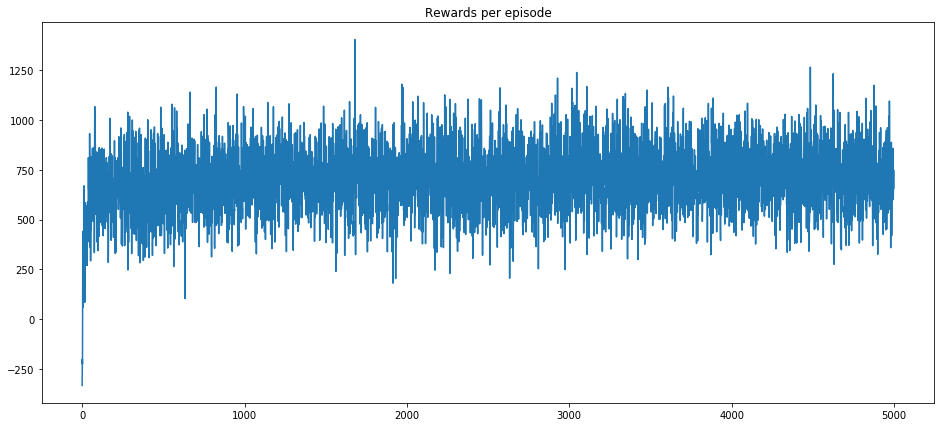

In [86]:
plt.figure(0, figsize=(16,7))
plt.title('Rewards per episode')
plt.plot(episodes,rewards_per_episode)

In [87]:
#time = np.arange(0,10000)
#epsilon = []
#for i in range(0,10000):
#    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

In [88]:
#plt.plot(time, epsilon)
#plt.show()

In [89]:
### Reducing Learning rate Further

In [90]:
#### Final DQN block LR 0.001 and Episodes 5000

In [91]:
#Under Test
learning_rate = 0.001
agent = DQNAgent(36,21,learning_rate)
rewards_per_episode, episodes = [], []

for episode in range(Episodes):

    # Write code here
   
    # Call all the initialised variables of the environment
    state_space = env.state_space
    action_space = env.action_space
    state = env.state_init
    print("Initial State is ",state)
    time = 0
    #Call the DQN agent
    terminal_state = False
    score = 0
    action = agent.get_action(env.state_encod_arch1(state),env)
    score += env.reward_func(state,action_space[action],Time_matrix)
    next_state,ride_time = env.next_state_func(state,action_space[action],Time_matrix)
    time += ride_time
    if time >= 24*30:
        agent.append_sample(env.state_encod_arch1(state),action,score,env.state_encod_arch1(next_state),True)
    else:
        agent.append_sample(env.state_encod_arch1(state),action,score,env.state_encod_arch1(next_state),False)
    loop = 0
    while not terminal_state:
        
        # Write your code here
        
        if time >= 24*30:
            terminal_state = True
            pass
        state = next_state
        # 1. Pick epsilon-greedy action from possible actions for the current state
        action = agent.get_action(env.state_encod_arch1(state),env)
        # 2. Evaluate your reward and next state
        reward_curr_ride = env.reward_func(state,action_space[action],Time_matrix)
        score+= reward_curr_ride
        next_state,ride_time = env.next_state_func(next_state,action_space[action],Time_matrix)
        time += ride_time
        # 3. Append the experience to the memory
        if time >= 24*30:
            agent.append_sample(env.state_encod_arch1(state),action,reward_curr_ride,env.state_encod_arch1(next_state),True)
        else:
            agent.append_sample(env.state_encod_arch1(state),action,reward_curr_ride,env.state_encod_arch1(next_state),False)
        # 4. Train the model by calling function agent.train_model
        agent.train_model(env)
        #print('Time elapsed {} and current loop {}'.format(time,loop))
        loop+= 1
        # 5. Keep a track of rewards, Q-values, loss
    
    rewards_per_episode.append(score)   
    episodes.append(episode)
    
    if agent.epsilon > agent.epsilon_min:
        agent.epsilon *= agent.epsilon_decay
# every episode:
    print("episode {0}, reward {1}, memory_length {2}, epsilon {3}, time {4}, rides {5}".format(episode,
                                                                         score,
                                                                         len(agent.memory),
                                                                         agent.epsilon,time,loop))
    # every few episodes:
        # Save the Q_value of the state, action pair we are tracking
    if ((episode + 1) % 5 == 0):
        agent.save_tracking_states()
    if episode % 1000 == 0:
        # store q-values of some prespecified state-action pairs
        # q_dict = agent.store_q_values()

        # save model weights
        agent.save(name="model_weights.h5")

Initial State is  [1, 13, 1]
episode 0, reward -7.0, memory_length 119, epsilon 0.0005, time 742.0, rides 118
Initial State is  [1, 13, 1]
episode 1, reward -53.0, memory_length 216, epsilon 0.0005, time 727.0, rides 96
Initial State is  [1, 13, 1]
episode 2, reward 66.0, memory_length 318, epsilon 0.0005, time 725.0, rides 101
Initial State is  [1, 13, 1]
episode 3, reward 61.0, memory_length 429, epsilon 0.0005, time 732.0, rides 110
Initial State is  [1, 13, 1]
episode 4, reward 28.0, memory_length 525, epsilon 0.0005, time 736.0, rides 95
Initial State is  [1, 13, 1]
episode 5, reward 58.0, memory_length 620, epsilon 0.0005, time 737.0, rides 94
Initial State is  [1, 13, 1]
episode 6, reward 86.0, memory_length 723, epsilon 0.0005, time 730.0, rides 102
Initial State is  [1, 13, 1]
episode 7, reward 196.0, memory_length 836, epsilon 0.0005, time 727.0, rides 112
Initial State is  [1, 13, 1]
episode 8, reward 334.0, memory_length 948, epsilon 0.0005, time 727.0, rides 111
Initial St

episode 73, reward 724.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 121
Initial State is  [1, 13, 1]
episode 74, reward 758.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 115
Initial State is  [1, 13, 1]
episode 75, reward 612.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 112
Initial State is  [1, 13, 1]
episode 76, reward 354.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 108
Initial State is  [1, 13, 1]
episode 77, reward 748.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 114
Initial State is  [1, 13, 1]
episode 78, reward 820.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 107
Initial State is  [1, 13, 1]
episode 79, reward 550.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 107
Initial State is  [1, 13, 1]
episode 80, reward 989.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 116
Initial State is  [1, 13, 1]
episode 81, reward 966.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 120
Initial Stat

episode 146, reward 656.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 118
Initial State is  [1, 13, 1]
episode 147, reward 416.0, memory_length 2000, epsilon 0.0005, time 738.0, rides 120
Initial State is  [1, 13, 1]
episode 148, reward 863.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 107
Initial State is  [1, 13, 1]
episode 149, reward 872.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 113
Initial State is  [1, 13, 1]
episode 150, reward 836.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 105
Initial State is  [1, 13, 1]
episode 151, reward 915.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 114
Initial State is  [1, 13, 1]
episode 152, reward 863.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 113
Initial State is  [1, 13, 1]
episode 153, reward 644.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 115
Initial State is  [1, 13, 1]
episode 154, reward 698.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 119
Ini

episode 218, reward 915.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 115
Initial State is  [1, 13, 1]
episode 219, reward 826.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 119
Initial State is  [1, 13, 1]
episode 220, reward 868.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 124
Initial State is  [1, 13, 1]
episode 221, reward 1003.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 115
Initial State is  [1, 13, 1]
episode 222, reward 928.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 108
Initial State is  [1, 13, 1]
episode 223, reward 509.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 112
Initial State is  [1, 13, 1]
episode 224, reward 749.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 126
Initial State is  [1, 13, 1]
episode 225, reward 709.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 114
Initial State is  [1, 13, 1]
episode 226, reward 600.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 126
In

episode 290, reward 425.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 117
Initial State is  [1, 13, 1]
episode 291, reward 971.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 117
Initial State is  [1, 13, 1]
episode 292, reward 849.0, memory_length 2000, epsilon 0.0005, time 740.0, rides 113
Initial State is  [1, 13, 1]
episode 293, reward 769.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 124
Initial State is  [1, 13, 1]
episode 294, reward 1001.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 127
Initial State is  [1, 13, 1]
episode 295, reward 949.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 112
Initial State is  [1, 13, 1]
episode 296, reward 793.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 121
Initial State is  [1, 13, 1]
episode 297, reward 869.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 103
Initial State is  [1, 13, 1]
episode 298, reward 936.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 109
In

episode 362, reward 1091.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 119
Initial State is  [1, 13, 1]
episode 363, reward 794.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 120
Initial State is  [1, 13, 1]
episode 364, reward 1030.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 123
Initial State is  [1, 13, 1]
episode 365, reward 1176.0, memory_length 2000, epsilon 0.0005, time 738.0, rides 120
Initial State is  [1, 13, 1]
episode 366, reward 769.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 110
Initial State is  [1, 13, 1]
episode 367, reward 692.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 115
Initial State is  [1, 13, 1]
episode 368, reward 1164.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 120
Initial State is  [1, 13, 1]
episode 369, reward 1001.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 122
Initial State is  [1, 13, 1]
episode 370, reward 1000.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 1

episode 434, reward 757.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 115
Initial State is  [1, 13, 1]
episode 435, reward 1070.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 129
Initial State is  [1, 13, 1]
episode 436, reward 828.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 105
Initial State is  [1, 13, 1]
episode 437, reward 614.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 123
Initial State is  [1, 13, 1]
episode 438, reward 862.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 116
Initial State is  [1, 13, 1]
episode 439, reward 1080.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 118
Initial State is  [1, 13, 1]
episode 440, reward 916.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 126
Initial State is  [1, 13, 1]
episode 441, reward 703.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 113
Initial State is  [1, 13, 1]
episode 442, reward 575.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 113
I

episode 506, reward 763.0, memory_length 2000, epsilon 0.0005, time 737.0, rides 125
Initial State is  [1, 13, 1]
episode 507, reward 802.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 114
Initial State is  [1, 13, 1]
episode 508, reward 749.0, memory_length 2000, epsilon 0.0005, time 740.0, rides 114
Initial State is  [1, 13, 1]
episode 509, reward 665.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 120
Initial State is  [1, 13, 1]
episode 510, reward 816.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 119
Initial State is  [1, 13, 1]
episode 511, reward 1194.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 116
Initial State is  [1, 13, 1]
episode 512, reward 799.0, memory_length 2000, epsilon 0.0005, time 750.0, rides 117
Initial State is  [1, 13, 1]
episode 513, reward 1029.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 106
Initial State is  [1, 13, 1]
episode 514, reward 922.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 128
I

episode 578, reward 859.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 116
Initial State is  [1, 13, 1]
episode 579, reward 928.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 101
Initial State is  [1, 13, 1]
episode 580, reward 593.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 119
Initial State is  [1, 13, 1]
episode 581, reward 623.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 106
Initial State is  [1, 13, 1]
episode 582, reward 987.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 122
Initial State is  [1, 13, 1]
episode 583, reward 954.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 112
Initial State is  [1, 13, 1]
episode 584, reward 1128.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 120
Initial State is  [1, 13, 1]
episode 585, reward 1060.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 118
Initial State is  [1, 13, 1]
episode 586, reward 821.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 118
I

episode 650, reward 982.0, memory_length 2000, epsilon 0.0005, time 738.0, rides 112
Initial State is  [1, 13, 1]
episode 651, reward 1245.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 116
Initial State is  [1, 13, 1]
episode 652, reward 1122.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 127
Initial State is  [1, 13, 1]
episode 653, reward 962.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 107
Initial State is  [1, 13, 1]
episode 654, reward 873.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 117
Initial State is  [1, 13, 1]
episode 655, reward 791.0, memory_length 2000, epsilon 0.0005, time 741.0, rides 118
Initial State is  [1, 13, 1]
episode 656, reward 555.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 108
Initial State is  [1, 13, 1]
episode 657, reward 991.0, memory_length 2000, epsilon 0.0005, time 740.0, rides 122
Initial State is  [1, 13, 1]
episode 658, reward 946.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 124
I

episode 722, reward 968.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 119
Initial State is  [1, 13, 1]
episode 723, reward 857.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 119
Initial State is  [1, 13, 1]
episode 724, reward 611.0, memory_length 2000, epsilon 0.0005, time 738.0, rides 114
Initial State is  [1, 13, 1]
episode 725, reward 772.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 118
Initial State is  [1, 13, 1]
episode 726, reward 1115.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 107
Initial State is  [1, 13, 1]
episode 727, reward 1053.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 126
Initial State is  [1, 13, 1]
episode 728, reward 1273.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 127
Initial State is  [1, 13, 1]
episode 729, reward 822.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 112
Initial State is  [1, 13, 1]
episode 730, reward 900.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 115


episode 794, reward 795.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 117
Initial State is  [1, 13, 1]
episode 795, reward 645.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 117
Initial State is  [1, 13, 1]
episode 796, reward 773.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 115
Initial State is  [1, 13, 1]
episode 797, reward 1043.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 110
Initial State is  [1, 13, 1]
episode 798, reward 838.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 117
Initial State is  [1, 13, 1]
episode 799, reward 758.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 112
Initial State is  [1, 13, 1]
episode 800, reward 1016.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 111
Initial State is  [1, 13, 1]
episode 801, reward 976.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 114
Initial State is  [1, 13, 1]
episode 802, reward 871.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 122
I

episode 866, reward 1104.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 117
Initial State is  [1, 13, 1]
episode 867, reward 879.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 115
Initial State is  [1, 13, 1]
episode 868, reward 976.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 111
Initial State is  [1, 13, 1]
episode 869, reward 959.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 112
Initial State is  [1, 13, 1]
episode 870, reward 951.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 127
Initial State is  [1, 13, 1]
episode 871, reward 1003.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 101
Initial State is  [1, 13, 1]
episode 872, reward 985.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 116
Initial State is  [1, 13, 1]
episode 873, reward 924.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 112
Initial State is  [1, 13, 1]
episode 874, reward 1114.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 123


episode 938, reward 945.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 116
Initial State is  [1, 13, 1]
episode 939, reward 1132.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 116
Initial State is  [1, 13, 1]
episode 940, reward 792.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 114
Initial State is  [1, 13, 1]
episode 941, reward 1069.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 117
Initial State is  [1, 13, 1]
episode 942, reward 1195.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 125
Initial State is  [1, 13, 1]
episode 943, reward 808.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 119
Initial State is  [1, 13, 1]
episode 944, reward 900.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 125
Initial State is  [1, 13, 1]
episode 945, reward 1200.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 113
Initial State is  [1, 13, 1]
episode 946, reward 712.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 120

episode 1010, reward 765.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 110
Initial State is  [1, 13, 1]
episode 1011, reward 740.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 120
Initial State is  [1, 13, 1]
episode 1012, reward 755.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 113
Initial State is  [1, 13, 1]
episode 1013, reward 1019.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 121
Initial State is  [1, 13, 1]
episode 1014, reward 913.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 114
Initial State is  [1, 13, 1]
episode 1015, reward 1091.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 111
Initial State is  [1, 13, 1]
episode 1016, reward 1262.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 122
Initial State is  [1, 13, 1]
episode 1017, reward 962.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 123
Initial State is  [1, 13, 1]
episode 1018, reward 991.0, memory_length 2000, epsilon 0.0005, time 734.0, r

episode 1082, reward 1130.0, memory_length 2000, epsilon 0.0005, time 740.0, rides 130
Initial State is  [1, 13, 1]
episode 1083, reward 1326.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 124
Initial State is  [1, 13, 1]
episode 1084, reward 822.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 117
Initial State is  [1, 13, 1]
episode 1085, reward 781.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 108
Initial State is  [1, 13, 1]
episode 1086, reward 1134.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 117
Initial State is  [1, 13, 1]
episode 1087, reward 733.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 111
Initial State is  [1, 13, 1]
episode 1088, reward 706.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 119
Initial State is  [1, 13, 1]
episode 1089, reward 763.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 116
Initial State is  [1, 13, 1]
episode 1090, reward 820.0, memory_length 2000, epsilon 0.0005, time 724.0, r

episode 1154, reward 1229.0, memory_length 2000, epsilon 0.0005, time 747.0, rides 114
Initial State is  [1, 13, 1]
episode 1155, reward 1020.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 109
Initial State is  [1, 13, 1]
episode 1156, reward 910.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 120
Initial State is  [1, 13, 1]
episode 1157, reward 799.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 123
Initial State is  [1, 13, 1]
episode 1158, reward 923.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 111
Initial State is  [1, 13, 1]
episode 1159, reward 907.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 121
Initial State is  [1, 13, 1]
episode 1160, reward 1089.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 113
Initial State is  [1, 13, 1]
episode 1161, reward 978.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 113
Initial State is  [1, 13, 1]
episode 1162, reward 1185.0, memory_length 2000, epsilon 0.0005, time 729.0, 

episode 1225, reward 978.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 114
Initial State is  [1, 13, 1]
episode 1226, reward 923.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 121
Initial State is  [1, 13, 1]
episode 1227, reward 1037.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 115
Initial State is  [1, 13, 1]
episode 1228, reward 827.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 108
Initial State is  [1, 13, 1]
episode 1229, reward 941.0, memory_length 2000, epsilon 0.0005, time 740.0, rides 127
Initial State is  [1, 13, 1]
episode 1230, reward 767.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 117
Initial State is  [1, 13, 1]
episode 1231, reward 939.0, memory_length 2000, epsilon 0.0005, time 738.0, rides 127
Initial State is  [1, 13, 1]
episode 1232, reward 1081.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 113
Initial State is  [1, 13, 1]
episode 1233, reward 1068.0, memory_length 2000, epsilon 0.0005, time 726.0, r

episode 1296, reward 954.0, memory_length 2000, epsilon 0.0005, time 741.0, rides 116
Initial State is  [1, 13, 1]
episode 1297, reward 1016.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 113
Initial State is  [1, 13, 1]
episode 1298, reward 930.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 116
Initial State is  [1, 13, 1]
episode 1299, reward 736.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 109
Initial State is  [1, 13, 1]
episode 1300, reward 1143.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 114
Initial State is  [1, 13, 1]
episode 1301, reward 952.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 121
Initial State is  [1, 13, 1]
episode 1302, reward 1174.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 119
Initial State is  [1, 13, 1]
episode 1303, reward 1048.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 110
Initial State is  [1, 13, 1]
episode 1304, reward 767.0, memory_length 2000, epsilon 0.0005, time 727.0, 

episode 1367, reward 1043.0, memory_length 2000, epsilon 0.0005, time 737.0, rides 116
Initial State is  [1, 13, 1]
episode 1368, reward 1147.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 109
Initial State is  [1, 13, 1]
episode 1369, reward 872.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 112
Initial State is  [1, 13, 1]
episode 1370, reward 1197.0, memory_length 2000, epsilon 0.0005, time 741.0, rides 123
Initial State is  [1, 13, 1]
episode 1371, reward 929.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 117
Initial State is  [1, 13, 1]
episode 1372, reward 977.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 111
Initial State is  [1, 13, 1]
episode 1373, reward 721.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 113
Initial State is  [1, 13, 1]
episode 1374, reward 925.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 115
Initial State is  [1, 13, 1]
episode 1375, reward 910.0, memory_length 2000, epsilon 0.0005, time 738.0, r

episode 1438, reward 762.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 119
Initial State is  [1, 13, 1]
episode 1439, reward 957.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 116
Initial State is  [1, 13, 1]
episode 1440, reward 1251.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 114
Initial State is  [1, 13, 1]
episode 1441, reward 1218.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 113
Initial State is  [1, 13, 1]
episode 1442, reward 830.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 112
Initial State is  [1, 13, 1]
episode 1443, reward 1268.0, memory_length 2000, epsilon 0.0005, time 740.0, rides 123
Initial State is  [1, 13, 1]
episode 1444, reward 1089.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 119
Initial State is  [1, 13, 1]
episode 1445, reward 1041.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 118
Initial State is  [1, 13, 1]
episode 1446, reward 1148.0, memory_length 2000, epsilon 0.0005, time 732.0

episode 1509, reward 654.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 116
Initial State is  [1, 13, 1]
episode 1510, reward 1303.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 119
Initial State is  [1, 13, 1]
episode 1511, reward 1135.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 117
Initial State is  [1, 13, 1]
episode 1512, reward 1188.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 123
Initial State is  [1, 13, 1]
episode 1513, reward 1257.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 117
Initial State is  [1, 13, 1]
episode 1514, reward 959.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 119
Initial State is  [1, 13, 1]
episode 1515, reward 886.0, memory_length 2000, epsilon 0.0005, time 721.0, rides 107
Initial State is  [1, 13, 1]
episode 1516, reward 986.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 122
Initial State is  [1, 13, 1]
episode 1517, reward 885.0, memory_length 2000, epsilon 0.0005, time 721.0, 

episode 1580, reward 798.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 114
Initial State is  [1, 13, 1]
episode 1581, reward 1187.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 124
Initial State is  [1, 13, 1]
episode 1582, reward 1040.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 111
Initial State is  [1, 13, 1]
episode 1583, reward 1006.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 117
Initial State is  [1, 13, 1]
episode 1584, reward 1027.0, memory_length 2000, epsilon 0.0005, time 738.0, rides 125
Initial State is  [1, 13, 1]
episode 1585, reward 1001.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 116
Initial State is  [1, 13, 1]
episode 1586, reward 753.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 115
Initial State is  [1, 13, 1]
episode 1587, reward 1082.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 113
Initial State is  [1, 13, 1]
episode 1588, reward 1147.0, memory_length 2000, epsilon 0.0005, time 721.

episode 1651, reward 1214.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 122
Initial State is  [1, 13, 1]
episode 1652, reward 852.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 109
Initial State is  [1, 13, 1]
episode 1653, reward 1147.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 128
Initial State is  [1, 13, 1]
episode 1654, reward 1256.0, memory_length 2000, epsilon 0.0005, time 741.0, rides 120
Initial State is  [1, 13, 1]
episode 1655, reward 1101.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 122
Initial State is  [1, 13, 1]
episode 1656, reward 1060.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 121
Initial State is  [1, 13, 1]
episode 1657, reward 751.0, memory_length 2000, epsilon 0.0005, time 721.0, rides 115
Initial State is  [1, 13, 1]
episode 1658, reward 1100.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 129
Initial State is  [1, 13, 1]
episode 1659, reward 869.0, memory_length 2000, epsilon 0.0005, time 728.0

episode 1722, reward 1172.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 124
Initial State is  [1, 13, 1]
episode 1723, reward 804.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 117
Initial State is  [1, 13, 1]
episode 1724, reward 1178.0, memory_length 2000, epsilon 0.0005, time 741.0, rides 122
Initial State is  [1, 13, 1]
episode 1725, reward 1032.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 125
Initial State is  [1, 13, 1]
episode 1726, reward 982.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 113
Initial State is  [1, 13, 1]
episode 1727, reward 1027.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 131
Initial State is  [1, 13, 1]
episode 1728, reward 800.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 123
Initial State is  [1, 13, 1]
episode 1729, reward 1102.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 116
Initial State is  [1, 13, 1]
episode 1730, reward 922.0, memory_length 2000, epsilon 0.0005, time 731.0,

episode 1793, reward 756.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 114
Initial State is  [1, 13, 1]
episode 1794, reward 1012.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 119
Initial State is  [1, 13, 1]
episode 1795, reward 1002.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 121
Initial State is  [1, 13, 1]
episode 1796, reward 811.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 109
Initial State is  [1, 13, 1]
episode 1797, reward 838.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 120
Initial State is  [1, 13, 1]
episode 1798, reward 1320.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 123
Initial State is  [1, 13, 1]
episode 1799, reward 1170.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 118
Initial State is  [1, 13, 1]
episode 1800, reward 819.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 118
Initial State is  [1, 13, 1]
episode 1801, reward 897.0, memory_length 2000, epsilon 0.0005, time 730.0, 

episode 1864, reward 1063.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 122
Initial State is  [1, 13, 1]
episode 1865, reward 1179.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 121
Initial State is  [1, 13, 1]
episode 1866, reward 998.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 124
Initial State is  [1, 13, 1]
episode 1867, reward 864.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 115
Initial State is  [1, 13, 1]
episode 1868, reward 831.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 117
Initial State is  [1, 13, 1]
episode 1869, reward 950.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 109
Initial State is  [1, 13, 1]
episode 1870, reward 1013.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 127
Initial State is  [1, 13, 1]
episode 1871, reward 1043.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 113
Initial State is  [1, 13, 1]
episode 1872, reward 1027.0, memory_length 2000, epsilon 0.0005, time 738.0,

episode 1935, reward 1036.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 125
Initial State is  [1, 13, 1]
episode 1936, reward 1084.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 122
Initial State is  [1, 13, 1]
episode 1937, reward 727.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 122
Initial State is  [1, 13, 1]
episode 1938, reward 1128.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 120
Initial State is  [1, 13, 1]
episode 1939, reward 966.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 120
Initial State is  [1, 13, 1]
episode 1940, reward 964.0, memory_length 2000, epsilon 0.0005, time 740.0, rides 114
Initial State is  [1, 13, 1]
episode 1941, reward 1021.0, memory_length 2000, epsilon 0.0005, time 738.0, rides 124
Initial State is  [1, 13, 1]
episode 1942, reward 1264.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 118
Initial State is  [1, 13, 1]
episode 1943, reward 1316.0, memory_length 2000, epsilon 0.0005, time 737.0

episode 2006, reward 973.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 124
Initial State is  [1, 13, 1]
episode 2007, reward 1158.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 131
Initial State is  [1, 13, 1]
episode 2008, reward 1048.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 113
Initial State is  [1, 13, 1]
episode 2009, reward 1076.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 122
Initial State is  [1, 13, 1]
episode 2010, reward 953.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 115
Initial State is  [1, 13, 1]
episode 2011, reward 745.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 115
Initial State is  [1, 13, 1]
episode 2012, reward 1051.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 128
Initial State is  [1, 13, 1]
episode 2013, reward 1102.0, memory_length 2000, epsilon 0.0005, time 739.0, rides 122
Initial State is  [1, 13, 1]
episode 2014, reward 992.0, memory_length 2000, epsilon 0.0005, time 723.0,

episode 2077, reward 1267.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 123
Initial State is  [1, 13, 1]
episode 2078, reward 857.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 112
Initial State is  [1, 13, 1]
episode 2079, reward 864.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 116
Initial State is  [1, 13, 1]
episode 2080, reward 1075.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 131
Initial State is  [1, 13, 1]
episode 2081, reward 1208.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 122
Initial State is  [1, 13, 1]
episode 2082, reward 651.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 116
Initial State is  [1, 13, 1]
episode 2083, reward 1119.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 120
Initial State is  [1, 13, 1]
episode 2084, reward 786.0, memory_length 2000, epsilon 0.0005, time 739.0, rides 108
Initial State is  [1, 13, 1]
episode 2085, reward 1065.0, memory_length 2000, epsilon 0.0005, time 738.0,

episode 2148, reward 1101.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 118
Initial State is  [1, 13, 1]
episode 2149, reward 1118.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 116
Initial State is  [1, 13, 1]
episode 2150, reward 961.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 121
Initial State is  [1, 13, 1]
episode 2151, reward 1136.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 120
Initial State is  [1, 13, 1]
episode 2152, reward 1151.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 120
Initial State is  [1, 13, 1]
episode 2153, reward 1115.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 114
Initial State is  [1, 13, 1]
episode 2154, reward 1259.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 122
Initial State is  [1, 13, 1]
episode 2155, reward 913.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 112
Initial State is  [1, 13, 1]
episode 2156, reward 1159.0, memory_length 2000, epsilon 0.0005, time 726.

episode 2219, reward 868.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 128
Initial State is  [1, 13, 1]
episode 2220, reward 1234.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 126
Initial State is  [1, 13, 1]
episode 2221, reward 1073.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 123
Initial State is  [1, 13, 1]
episode 2222, reward 1241.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 136
Initial State is  [1, 13, 1]
episode 2223, reward 1149.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 119
Initial State is  [1, 13, 1]
episode 2224, reward 1387.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 119
Initial State is  [1, 13, 1]
episode 2225, reward 1125.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 123
Initial State is  [1, 13, 1]
episode 2226, reward 1024.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 134
Initial State is  [1, 13, 1]
episode 2227, reward 857.0, memory_length 2000, epsilon 0.0005, time 723.

episode 2290, reward 984.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 118
Initial State is  [1, 13, 1]
episode 2291, reward 1007.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 116
Initial State is  [1, 13, 1]
episode 2292, reward 918.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 113
Initial State is  [1, 13, 1]
episode 2293, reward 1104.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 124
Initial State is  [1, 13, 1]
episode 2294, reward 849.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 116
Initial State is  [1, 13, 1]
episode 2295, reward 1261.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 108
Initial State is  [1, 13, 1]
episode 2296, reward 957.0, memory_length 2000, epsilon 0.0005, time 745.0, rides 110
Initial State is  [1, 13, 1]
episode 2297, reward 979.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 122
Initial State is  [1, 13, 1]
episode 2298, reward 987.0, memory_length 2000, epsilon 0.0005, time 728.0, r

episode 2361, reward 1194.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 112
Initial State is  [1, 13, 1]
episode 2362, reward 973.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 113
Initial State is  [1, 13, 1]
episode 2363, reward 1058.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 127
Initial State is  [1, 13, 1]
episode 2364, reward 907.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 107
Initial State is  [1, 13, 1]
episode 2365, reward 1047.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 115
Initial State is  [1, 13, 1]
episode 2366, reward 1109.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 127
Initial State is  [1, 13, 1]
episode 2367, reward 1043.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 119
Initial State is  [1, 13, 1]
episode 2368, reward 1052.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 122
Initial State is  [1, 13, 1]
episode 2369, reward 928.0, memory_length 2000, epsilon 0.0005, time 726.0

episode 2432, reward 684.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 109
Initial State is  [1, 13, 1]
episode 2433, reward 839.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 117
Initial State is  [1, 13, 1]
episode 2434, reward 842.0, memory_length 2000, epsilon 0.0005, time 737.0, rides 119
Initial State is  [1, 13, 1]
episode 2435, reward 877.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 114
Initial State is  [1, 13, 1]
episode 2436, reward 866.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 116
Initial State is  [1, 13, 1]
episode 2437, reward 1219.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 114
Initial State is  [1, 13, 1]
episode 2438, reward 882.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 124
Initial State is  [1, 13, 1]
episode 2439, reward 892.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 124
Initial State is  [1, 13, 1]
episode 2440, reward 949.0, memory_length 2000, epsilon 0.0005, time 724.0, rid

episode 2503, reward 979.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 121
Initial State is  [1, 13, 1]
episode 2504, reward 1025.0, memory_length 2000, epsilon 0.0005, time 739.0, rides 121
Initial State is  [1, 13, 1]
episode 2505, reward 1018.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 114
Initial State is  [1, 13, 1]
episode 2506, reward 901.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 116
Initial State is  [1, 13, 1]
episode 2507, reward 1058.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 124
Initial State is  [1, 13, 1]
episode 2508, reward 1032.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 125
Initial State is  [1, 13, 1]
episode 2509, reward 974.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 119
Initial State is  [1, 13, 1]
episode 2510, reward 962.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 124
Initial State is  [1, 13, 1]
episode 2511, reward 1226.0, memory_length 2000, epsilon 0.0005, time 723.0,

episode 2574, reward 765.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 118
Initial State is  [1, 13, 1]
episode 2575, reward 937.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 115
Initial State is  [1, 13, 1]
episode 2576, reward 1245.0, memory_length 2000, epsilon 0.0005, time 740.0, rides 125
Initial State is  [1, 13, 1]
episode 2577, reward 1038.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 114
Initial State is  [1, 13, 1]
episode 2578, reward 1174.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 118
Initial State is  [1, 13, 1]
episode 2579, reward 982.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 115
Initial State is  [1, 13, 1]
episode 2580, reward 1229.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 122
Initial State is  [1, 13, 1]
episode 2581, reward 934.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 115
Initial State is  [1, 13, 1]
episode 2582, reward 1071.0, memory_length 2000, epsilon 0.0005, time 725.0,

episode 2645, reward 681.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 120
Initial State is  [1, 13, 1]
episode 2646, reward 1211.0, memory_length 2000, epsilon 0.0005, time 742.0, rides 117
Initial State is  [1, 13, 1]
episode 2647, reward 1017.0, memory_length 2000, epsilon 0.0005, time 738.0, rides 113
Initial State is  [1, 13, 1]
episode 2648, reward 1088.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 120
Initial State is  [1, 13, 1]
episode 2649, reward 1001.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 115
Initial State is  [1, 13, 1]
episode 2650, reward 1165.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 113
Initial State is  [1, 13, 1]
episode 2651, reward 1017.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 116
Initial State is  [1, 13, 1]
episode 2652, reward 844.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 119
Initial State is  [1, 13, 1]
episode 2653, reward 1100.0, memory_length 2000, epsilon 0.0005, time 732.

episode 2716, reward 1037.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 119
Initial State is  [1, 13, 1]
episode 2717, reward 1015.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 119
Initial State is  [1, 13, 1]
episode 2718, reward 722.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 113
Initial State is  [1, 13, 1]
episode 2719, reward 1248.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 119
Initial State is  [1, 13, 1]
episode 2720, reward 1178.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 122
Initial State is  [1, 13, 1]
episode 2721, reward 1016.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 130
Initial State is  [1, 13, 1]
episode 2722, reward 1046.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 120
Initial State is  [1, 13, 1]
episode 2723, reward 1161.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 129
Initial State is  [1, 13, 1]
episode 2724, reward 1226.0, memory_length 2000, epsilon 0.0005, time 728

episode 2787, reward 854.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 112
Initial State is  [1, 13, 1]
episode 2788, reward 1095.0, memory_length 2000, epsilon 0.0005, time 746.0, rides 116
Initial State is  [1, 13, 1]
episode 2789, reward 1219.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 120
Initial State is  [1, 13, 1]
episode 2790, reward 1175.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 133
Initial State is  [1, 13, 1]
episode 2791, reward 697.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 121
Initial State is  [1, 13, 1]
episode 2792, reward 952.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 118
Initial State is  [1, 13, 1]
episode 2793, reward 868.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 129
Initial State is  [1, 13, 1]
episode 2794, reward 953.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 118
Initial State is  [1, 13, 1]
episode 2795, reward 938.0, memory_length 2000, epsilon 0.0005, time 736.0, r

episode 2858, reward 1094.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 120
Initial State is  [1, 13, 1]
episode 2859, reward 1057.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 125
Initial State is  [1, 13, 1]
episode 2860, reward 901.0, memory_length 2000, epsilon 0.0005, time 741.0, rides 119
Initial State is  [1, 13, 1]
episode 2861, reward 1138.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 114
Initial State is  [1, 13, 1]
episode 2862, reward 1015.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 116
Initial State is  [1, 13, 1]
episode 2863, reward 1032.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 119
Initial State is  [1, 13, 1]
episode 2864, reward 878.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 119
Initial State is  [1, 13, 1]
episode 2865, reward 603.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 109
Initial State is  [1, 13, 1]
episode 2866, reward 859.0, memory_length 2000, epsilon 0.0005, time 735.0,

episode 2929, reward 1104.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 114
Initial State is  [1, 13, 1]
episode 2930, reward 1107.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 117
Initial State is  [1, 13, 1]
episode 2931, reward 1114.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 124
Initial State is  [1, 13, 1]
episode 2932, reward 1245.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 133
Initial State is  [1, 13, 1]
episode 2933, reward 995.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 125
Initial State is  [1, 13, 1]
episode 2934, reward 1098.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 120
Initial State is  [1, 13, 1]
episode 2935, reward 1392.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 122
Initial State is  [1, 13, 1]
episode 2936, reward 973.0, memory_length 2000, epsilon 0.0005, time 742.0, rides 124
Initial State is  [1, 13, 1]
episode 2937, reward 900.0, memory_length 2000, epsilon 0.0005, time 732.0

episode 3000, reward 1087.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 128
Initial State is  [1, 13, 1]
episode 3001, reward 1080.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 122
Initial State is  [1, 13, 1]
episode 3002, reward 1319.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 115
Initial State is  [1, 13, 1]
episode 3003, reward 707.0, memory_length 2000, epsilon 0.0005, time 737.0, rides 128
Initial State is  [1, 13, 1]
episode 3004, reward 1004.0, memory_length 2000, epsilon 0.0005, time 742.0, rides 121
Initial State is  [1, 13, 1]
episode 3005, reward 939.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 130
Initial State is  [1, 13, 1]
episode 3006, reward 1318.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 130
Initial State is  [1, 13, 1]
episode 3007, reward 857.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 118
Initial State is  [1, 13, 1]
episode 3008, reward 1136.0, memory_length 2000, epsilon 0.0005, time 729.0

episode 3071, reward 921.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 121
Initial State is  [1, 13, 1]
episode 3072, reward 957.0, memory_length 2000, epsilon 0.0005, time 737.0, rides 115
Initial State is  [1, 13, 1]
episode 3073, reward 1069.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 128
Initial State is  [1, 13, 1]
episode 3074, reward 858.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 113
Initial State is  [1, 13, 1]
episode 3075, reward 910.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 116
Initial State is  [1, 13, 1]
episode 3076, reward 1153.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 122
Initial State is  [1, 13, 1]
episode 3077, reward 1126.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 117
Initial State is  [1, 13, 1]
episode 3078, reward 894.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 127
Initial State is  [1, 13, 1]
episode 3079, reward 882.0, memory_length 2000, epsilon 0.0005, time 723.0, r

episode 3142, reward 1027.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 125
Initial State is  [1, 13, 1]
episode 3143, reward 1061.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 123
Initial State is  [1, 13, 1]
episode 3144, reward 945.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 113
Initial State is  [1, 13, 1]
episode 3145, reward 942.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 111
Initial State is  [1, 13, 1]
episode 3146, reward 1071.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 126
Initial State is  [1, 13, 1]
episode 3147, reward 1080.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 112
Initial State is  [1, 13, 1]
episode 3148, reward 899.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 115
Initial State is  [1, 13, 1]
episode 3149, reward 999.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 125
Initial State is  [1, 13, 1]
episode 3150, reward 852.0, memory_length 2000, epsilon 0.0005, time 731.0, 

episode 3213, reward 806.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 120
Initial State is  [1, 13, 1]
episode 3214, reward 854.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 120
Initial State is  [1, 13, 1]
episode 3215, reward 924.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 122
Initial State is  [1, 13, 1]
episode 3216, reward 899.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 118
Initial State is  [1, 13, 1]
episode 3217, reward 1585.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 129
Initial State is  [1, 13, 1]
episode 3218, reward 1153.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 118
Initial State is  [1, 13, 1]
episode 3219, reward 1226.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 122
Initial State is  [1, 13, 1]
episode 3220, reward 1078.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 117
Initial State is  [1, 13, 1]
episode 3221, reward 1028.0, memory_length 2000, epsilon 0.0005, time 725.0,

episode 3284, reward 968.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 126
Initial State is  [1, 13, 1]
episode 3285, reward 1282.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 122
Initial State is  [1, 13, 1]
episode 3286, reward 1009.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 138
Initial State is  [1, 13, 1]
episode 3287, reward 963.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 122
Initial State is  [1, 13, 1]
episode 3288, reward 1059.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 118
Initial State is  [1, 13, 1]
episode 3289, reward 985.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 126
Initial State is  [1, 13, 1]
episode 3290, reward 1241.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 128
Initial State is  [1, 13, 1]
episode 3291, reward 830.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 112
Initial State is  [1, 13, 1]
episode 3292, reward 1160.0, memory_length 2000, epsilon 0.0005, time 729.0,

episode 3355, reward 1096.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 128
Initial State is  [1, 13, 1]
episode 3356, reward 1062.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 120
Initial State is  [1, 13, 1]
episode 3357, reward 955.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 114
Initial State is  [1, 13, 1]
episode 3358, reward 832.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 128
Initial State is  [1, 13, 1]
episode 3359, reward 1089.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 130
Initial State is  [1, 13, 1]
episode 3360, reward 1061.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 120
Initial State is  [1, 13, 1]
episode 3361, reward 1154.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 116
Initial State is  [1, 13, 1]
episode 3362, reward 568.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 117
Initial State is  [1, 13, 1]
episode 3363, reward 879.0, memory_length 2000, epsilon 0.0005, time 727.0,

episode 3426, reward 899.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 117
Initial State is  [1, 13, 1]
episode 3427, reward 952.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 127
Initial State is  [1, 13, 1]
episode 3428, reward 1196.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 122
Initial State is  [1, 13, 1]
episode 3429, reward 1171.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 127
Initial State is  [1, 13, 1]
episode 3430, reward 1185.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 126
Initial State is  [1, 13, 1]
episode 3431, reward 1052.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 131
Initial State is  [1, 13, 1]
episode 3432, reward 1046.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 124
Initial State is  [1, 13, 1]
episode 3433, reward 1180.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 115
Initial State is  [1, 13, 1]
episode 3434, reward 1026.0, memory_length 2000, epsilon 0.0005, time 730.

episode 3497, reward 821.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 120
Initial State is  [1, 13, 1]
episode 3498, reward 1087.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 118
Initial State is  [1, 13, 1]
episode 3499, reward 877.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 119
Initial State is  [1, 13, 1]
episode 3500, reward 937.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 115
Initial State is  [1, 13, 1]
episode 3501, reward 1052.0, memory_length 2000, epsilon 0.0005, time 741.0, rides 126
Initial State is  [1, 13, 1]
episode 3502, reward 1101.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 123
Initial State is  [1, 13, 1]
episode 3503, reward 1197.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 124
Initial State is  [1, 13, 1]
episode 3504, reward 955.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 120
Initial State is  [1, 13, 1]
episode 3505, reward 1219.0, memory_length 2000, epsilon 0.0005, time 732.0,

episode 3568, reward 1201.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 128
Initial State is  [1, 13, 1]
episode 3569, reward 1342.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 120
Initial State is  [1, 13, 1]
episode 3570, reward 708.0, memory_length 2000, epsilon 0.0005, time 721.0, rides 116
Initial State is  [1, 13, 1]
episode 3571, reward 1049.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 119
Initial State is  [1, 13, 1]
episode 3572, reward 1027.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 127
Initial State is  [1, 13, 1]
episode 3573, reward 1313.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 121
Initial State is  [1, 13, 1]
episode 3574, reward 1083.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 120
Initial State is  [1, 13, 1]
episode 3575, reward 1020.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 114
Initial State is  [1, 13, 1]
episode 3576, reward 1419.0, memory_length 2000, epsilon 0.0005, time 734

episode 3639, reward 1256.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 121
Initial State is  [1, 13, 1]
episode 3640, reward 1304.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 126
Initial State is  [1, 13, 1]
episode 3641, reward 912.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 117
Initial State is  [1, 13, 1]
episode 3642, reward 788.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 110
Initial State is  [1, 13, 1]
episode 3643, reward 1206.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 127
Initial State is  [1, 13, 1]
episode 3644, reward 810.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 114
Initial State is  [1, 13, 1]
episode 3645, reward 862.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 108
Initial State is  [1, 13, 1]
episode 3646, reward 1287.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 125
Initial State is  [1, 13, 1]
episode 3647, reward 888.0, memory_length 2000, epsilon 0.0005, time 729.0, 

episode 3710, reward 1074.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 121
Initial State is  [1, 13, 1]
episode 3711, reward 799.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 117
Initial State is  [1, 13, 1]
episode 3712, reward 1298.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 125
Initial State is  [1, 13, 1]
episode 3713, reward 1019.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 113
Initial State is  [1, 13, 1]
episode 3714, reward 1155.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 122
Initial State is  [1, 13, 1]
episode 3715, reward 984.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 121
Initial State is  [1, 13, 1]
episode 3716, reward 1233.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 114
Initial State is  [1, 13, 1]
episode 3717, reward 847.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 112
Initial State is  [1, 13, 1]
episode 3718, reward 947.0, memory_length 2000, epsilon 0.0005, time 722.0,

episode 3781, reward 1189.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 123
Initial State is  [1, 13, 1]
episode 3782, reward 1128.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 126
Initial State is  [1, 13, 1]
episode 3783, reward 1121.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 118
Initial State is  [1, 13, 1]
episode 3784, reward 873.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 121
Initial State is  [1, 13, 1]
episode 3785, reward 1078.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 115
Initial State is  [1, 13, 1]
episode 3786, reward 941.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 121
Initial State is  [1, 13, 1]
episode 3787, reward 986.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 124
Initial State is  [1, 13, 1]
episode 3788, reward 1011.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 116
Initial State is  [1, 13, 1]
episode 3789, reward 1061.0, memory_length 2000, epsilon 0.0005, time 734.0

episode 3852, reward 947.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 124
Initial State is  [1, 13, 1]
episode 3853, reward 1253.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 122
Initial State is  [1, 13, 1]
episode 3854, reward 853.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 110
Initial State is  [1, 13, 1]
episode 3855, reward 1084.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 112
Initial State is  [1, 13, 1]
episode 3856, reward 1093.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 125
Initial State is  [1, 13, 1]
episode 3857, reward 1038.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 122
Initial State is  [1, 13, 1]
episode 3858, reward 1155.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 120
Initial State is  [1, 13, 1]
episode 3859, reward 984.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 118
Initial State is  [1, 13, 1]
episode 3860, reward 778.0, memory_length 2000, epsilon 0.0005, time 732.0,

episode 3923, reward 993.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 118
Initial State is  [1, 13, 1]
episode 3924, reward 920.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 114
Initial State is  [1, 13, 1]
episode 3925, reward 1001.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 120
Initial State is  [1, 13, 1]
episode 3926, reward 1314.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 121
Initial State is  [1, 13, 1]
episode 3927, reward 953.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 118
Initial State is  [1, 13, 1]
episode 3928, reward 784.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 110
Initial State is  [1, 13, 1]
episode 3929, reward 850.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 125
Initial State is  [1, 13, 1]
episode 3930, reward 1041.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 110
Initial State is  [1, 13, 1]
episode 3931, reward 1077.0, memory_length 2000, epsilon 0.0005, time 729.0, 

episode 3994, reward 1003.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 119
Initial State is  [1, 13, 1]
episode 3995, reward 1092.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 116
Initial State is  [1, 13, 1]
episode 3996, reward 1106.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 111
Initial State is  [1, 13, 1]
episode 3997, reward 1096.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 126
Initial State is  [1, 13, 1]
episode 3998, reward 827.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 115
Initial State is  [1, 13, 1]
episode 3999, reward 786.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 121
Initial State is  [1, 13, 1]
episode 4000, reward 1023.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 116
Initial State is  [1, 13, 1]
episode 4001, reward 996.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 115
Initial State is  [1, 13, 1]
episode 4002, reward 973.0, memory_length 2000, epsilon 0.0005, time 727.0,

episode 4065, reward 1070.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 120
Initial State is  [1, 13, 1]
episode 4066, reward 869.0, memory_length 2000, epsilon 0.0005, time 736.0, rides 116
Initial State is  [1, 13, 1]
episode 4067, reward 1161.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 119
Initial State is  [1, 13, 1]
episode 4068, reward 1159.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 130
Initial State is  [1, 13, 1]
episode 4069, reward 1110.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 128
Initial State is  [1, 13, 1]
episode 4070, reward 945.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 115
Initial State is  [1, 13, 1]
episode 4071, reward 898.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 123
Initial State is  [1, 13, 1]
episode 4072, reward 1304.0, memory_length 2000, epsilon 0.0005, time 735.0, rides 123
Initial State is  [1, 13, 1]
episode 4073, reward 1171.0, memory_length 2000, epsilon 0.0005, time 727.0

episode 4136, reward 719.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 122
Initial State is  [1, 13, 1]
episode 4137, reward 845.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 118
Initial State is  [1, 13, 1]
episode 4138, reward 987.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 126
Initial State is  [1, 13, 1]
episode 4139, reward 1243.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 127
Initial State is  [1, 13, 1]
episode 4140, reward 930.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 122
Initial State is  [1, 13, 1]
episode 4141, reward 746.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 100
Initial State is  [1, 13, 1]
episode 4142, reward 1064.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 119
Initial State is  [1, 13, 1]
episode 4143, reward 801.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 117
Initial State is  [1, 13, 1]
episode 4144, reward 1048.0, memory_length 2000, epsilon 0.0005, time 724.0, r

episode 4207, reward 1364.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 128
Initial State is  [1, 13, 1]
episode 4208, reward 1074.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 131
Initial State is  [1, 13, 1]
episode 4209, reward 1056.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 136
Initial State is  [1, 13, 1]
episode 4210, reward 954.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 123
Initial State is  [1, 13, 1]
episode 4211, reward 1204.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 123
Initial State is  [1, 13, 1]
episode 4212, reward 1029.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 122
Initial State is  [1, 13, 1]
episode 4213, reward 1322.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 132
Initial State is  [1, 13, 1]
episode 4214, reward 665.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 108
Initial State is  [1, 13, 1]
episode 4215, reward 1029.0, memory_length 2000, epsilon 0.0005, time 724.

episode 4278, reward 1078.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 112
Initial State is  [1, 13, 1]
episode 4279, reward 815.0, memory_length 2000, epsilon 0.0005, time 721.0, rides 114
Initial State is  [1, 13, 1]
episode 4280, reward 1423.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 126
Initial State is  [1, 13, 1]
episode 4281, reward 1385.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 126
Initial State is  [1, 13, 1]
episode 4282, reward 1025.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 124
Initial State is  [1, 13, 1]
episode 4283, reward 1068.0, memory_length 2000, epsilon 0.0005, time 741.0, rides 118
Initial State is  [1, 13, 1]
episode 4284, reward 845.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 117
Initial State is  [1, 13, 1]
episode 4285, reward 1197.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 116
Initial State is  [1, 13, 1]
episode 4286, reward 1084.0, memory_length 2000, epsilon 0.0005, time 736.

episode 4349, reward 974.0, memory_length 2000, epsilon 0.0005, time 738.0, rides 118
Initial State is  [1, 13, 1]
episode 4350, reward 1235.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 122
Initial State is  [1, 13, 1]
episode 4351, reward 931.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 115
Initial State is  [1, 13, 1]
episode 4352, reward 841.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 121
Initial State is  [1, 13, 1]
episode 4353, reward 1330.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 123
Initial State is  [1, 13, 1]
episode 4354, reward 1020.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 119
Initial State is  [1, 13, 1]
episode 4355, reward 1283.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 127
Initial State is  [1, 13, 1]
episode 4356, reward 1044.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 107
Initial State is  [1, 13, 1]
episode 4357, reward 928.0, memory_length 2000, epsilon 0.0005, time 727.0,

episode 4420, reward 1095.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 118
Initial State is  [1, 13, 1]
episode 4421, reward 1300.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 121
Initial State is  [1, 13, 1]
episode 4422, reward 980.0, memory_length 2000, epsilon 0.0005, time 740.0, rides 117
Initial State is  [1, 13, 1]
episode 4423, reward 1072.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 114
Initial State is  [1, 13, 1]
episode 4424, reward 751.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 109
Initial State is  [1, 13, 1]
episode 4425, reward 993.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 109
Initial State is  [1, 13, 1]
episode 4426, reward 1263.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 130
Initial State is  [1, 13, 1]
episode 4427, reward 1171.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 120
Initial State is  [1, 13, 1]
episode 4428, reward 1359.0, memory_length 2000, epsilon 0.0005, time 730.0

episode 4491, reward 1120.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 112
Initial State is  [1, 13, 1]
episode 4492, reward 1096.0, memory_length 2000, epsilon 0.0005, time 737.0, rides 110
Initial State is  [1, 13, 1]
episode 4493, reward 1199.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 115
Initial State is  [1, 13, 1]
episode 4494, reward 1144.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 115
Initial State is  [1, 13, 1]
episode 4495, reward 1076.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 110
Initial State is  [1, 13, 1]
episode 4496, reward 1461.0, memory_length 2000, epsilon 0.0005, time 726.0, rides 122
Initial State is  [1, 13, 1]
episode 4497, reward 1175.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 115
Initial State is  [1, 13, 1]
episode 4498, reward 1038.0, memory_length 2000, epsilon 0.0005, time 739.0, rides 112
Initial State is  [1, 13, 1]
episode 4499, reward 1383.0, memory_length 2000, epsilon 0.0005, time 72

episode 4562, reward 1242.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 120
Initial State is  [1, 13, 1]
episode 4563, reward 1276.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 111
Initial State is  [1, 13, 1]
episode 4564, reward 1269.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 123
Initial State is  [1, 13, 1]
episode 4565, reward 894.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 113
Initial State is  [1, 13, 1]
episode 4566, reward 1333.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 122
Initial State is  [1, 13, 1]
episode 4567, reward 1203.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 126
Initial State is  [1, 13, 1]
episode 4568, reward 824.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 108
Initial State is  [1, 13, 1]
episode 4569, reward 1062.0, memory_length 2000, epsilon 0.0005, time 739.0, rides 118
Initial State is  [1, 13, 1]
episode 4570, reward 983.0, memory_length 2000, epsilon 0.0005, time 729.0

episode 4633, reward 1125.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 120
Initial State is  [1, 13, 1]
episode 4634, reward 1358.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 118
Initial State is  [1, 13, 1]
episode 4635, reward 1248.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 120
Initial State is  [1, 13, 1]
episode 4636, reward 952.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 106
Initial State is  [1, 13, 1]
episode 4637, reward 1090.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 127
Initial State is  [1, 13, 1]
episode 4638, reward 1027.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 114
Initial State is  [1, 13, 1]
episode 4639, reward 945.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 117
Initial State is  [1, 13, 1]
episode 4640, reward 898.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 120
Initial State is  [1, 13, 1]
episode 4641, reward 1155.0, memory_length 2000, epsilon 0.0005, time 732.0

episode 4704, reward 1046.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 115
Initial State is  [1, 13, 1]
episode 4705, reward 1077.0, memory_length 2000, epsilon 0.0005, time 740.0, rides 114
Initial State is  [1, 13, 1]
episode 4706, reward 1153.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 117
Initial State is  [1, 13, 1]
episode 4707, reward 1342.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 125
Initial State is  [1, 13, 1]
episode 4708, reward 842.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 107
Initial State is  [1, 13, 1]
episode 4709, reward 1208.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 107
Initial State is  [1, 13, 1]
episode 4710, reward 972.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 115
Initial State is  [1, 13, 1]
episode 4711, reward 1082.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 118
Initial State is  [1, 13, 1]
episode 4712, reward 1154.0, memory_length 2000, epsilon 0.0005, time 732.

episode 4775, reward 1204.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 122
Initial State is  [1, 13, 1]
episode 4776, reward 1004.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 116
Initial State is  [1, 13, 1]
episode 4777, reward 1356.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 126
Initial State is  [1, 13, 1]
episode 4778, reward 977.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 104
Initial State is  [1, 13, 1]
episode 4779, reward 1218.0, memory_length 2000, epsilon 0.0005, time 731.0, rides 123
Initial State is  [1, 13, 1]
episode 4780, reward 1404.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 130
Initial State is  [1, 13, 1]
episode 4781, reward 1057.0, memory_length 2000, epsilon 0.0005, time 729.0, rides 115
Initial State is  [1, 13, 1]
episode 4782, reward 1030.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 115
Initial State is  [1, 13, 1]
episode 4783, reward 1369.0, memory_length 2000, epsilon 0.0005, time 731

episode 4846, reward 1335.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 128
Initial State is  [1, 13, 1]
episode 4847, reward 964.0, memory_length 2000, epsilon 0.0005, time 732.0, rides 116
Initial State is  [1, 13, 1]
episode 4848, reward 1342.0, memory_length 2000, epsilon 0.0005, time 725.0, rides 114
Initial State is  [1, 13, 1]
episode 4849, reward 1221.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 117
Initial State is  [1, 13, 1]
episode 4850, reward 1071.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 119
Initial State is  [1, 13, 1]
episode 4851, reward 1111.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 123
Initial State is  [1, 13, 1]
episode 4852, reward 1371.0, memory_length 2000, epsilon 0.0005, time 722.0, rides 118
Initial State is  [1, 13, 1]
episode 4853, reward 1073.0, memory_length 2000, epsilon 0.0005, time 724.0, rides 118
Initial State is  [1, 13, 1]
episode 4854, reward 1026.0, memory_length 2000, epsilon 0.0005, time 733

episode 4917, reward 1142.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 118
Initial State is  [1, 13, 1]
episode 4918, reward 1092.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 126
Initial State is  [1, 13, 1]
episode 4919, reward 1294.0, memory_length 2000, epsilon 0.0005, time 733.0, rides 126
Initial State is  [1, 13, 1]
episode 4920, reward 1025.0, memory_length 2000, epsilon 0.0005, time 743.0, rides 116
Initial State is  [1, 13, 1]
episode 4921, reward 1093.0, memory_length 2000, epsilon 0.0005, time 737.0, rides 125
Initial State is  [1, 13, 1]
episode 4922, reward 948.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 106
Initial State is  [1, 13, 1]
episode 4923, reward 1208.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 123
Initial State is  [1, 13, 1]
episode 4924, reward 1251.0, memory_length 2000, epsilon 0.0005, time 723.0, rides 121
Initial State is  [1, 13, 1]
episode 4925, reward 1342.0, memory_length 2000, epsilon 0.0005, time 725

episode 4988, reward 962.0, memory_length 2000, epsilon 0.0005, time 727.0, rides 113
Initial State is  [1, 13, 1]
episode 4989, reward 871.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 117
Initial State is  [1, 13, 1]
episode 4990, reward 852.0, memory_length 2000, epsilon 0.0005, time 734.0, rides 111
Initial State is  [1, 13, 1]
episode 4991, reward 1034.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 121
Initial State is  [1, 13, 1]
episode 4992, reward 976.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 112
Initial State is  [1, 13, 1]
episode 4993, reward 1368.0, memory_length 2000, epsilon 0.0005, time 728.0, rides 122
Initial State is  [1, 13, 1]
episode 4994, reward 1113.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 124
Initial State is  [1, 13, 1]
episode 4995, reward 1201.0, memory_length 2000, epsilon 0.0005, time 730.0, rides 117
Initial State is  [1, 13, 1]
episode 4996, reward 1182.0, memory_length 2000, epsilon 0.0005, time 737.0,

In [92]:
agent.memory

deque([(array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 1.]),
        5,
        4.0,
        array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 1.]),
        False),
       (array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 1.]),
        17,
        -1.0,
        array([1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
               0., 0.]),
        False),
       (array([1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 

In [93]:
### Tracking Convergence

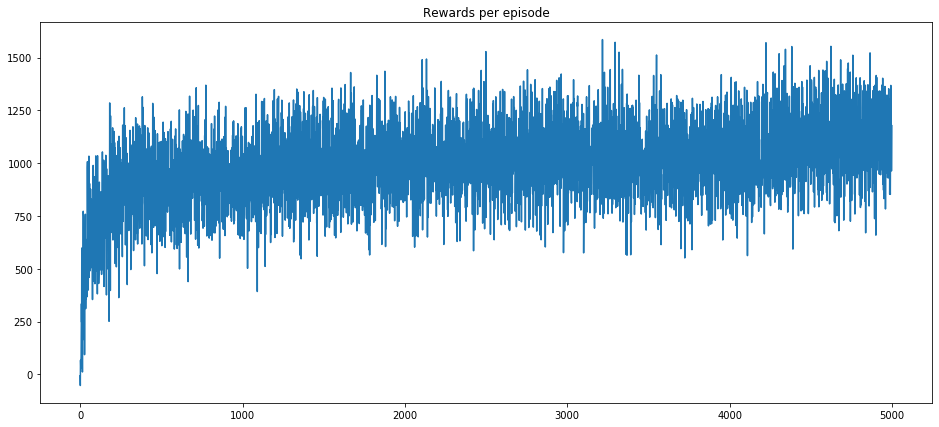

In [94]:
plt.figure(0, figsize=(16,7))
plt.title('Rewards per episode')
plt.plot(episodes,rewards_per_episode)

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [95]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

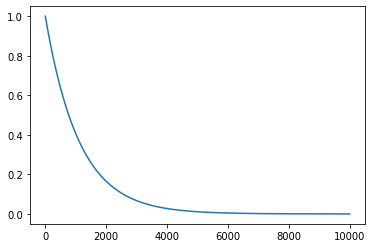

In [96]:
plt.plot(time, epsilon)
plt.show()